# Implémentation

In [132]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [7]:
import numpy as np
import pandas as pd
import gc
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [8]:
import os
os.getcwd()

'C:\\Users\\chiqu\\Documents\\Openclassrooms\\OC_P7'

In [9]:
os.chdir("C://Users//chiqu//Documents//Openclassrooms//OC_P7")
os.getcwd()

'C:\\Users\\chiqu\\Documents\\Openclassrooms\\OC_P7'

## Preprocessing

### Data frame building

In [34]:
import re


# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns= categorical_columns, dummy_na= nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

# Preprocess application_train.csv and application_test.csv
def application_train_test(num_rows = None, nan_as_category = False):
    # Read data and merge
    df = pd.read_csv('application_train.csv', nrows= num_rows)
    #df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    test_df = pd.read_csv('application_test.csv', nrows= num_rows)
    #test_df = test_df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    print("Train samples: {}, test samples: {}".format(len(df), len(test_df)))
    df = df.append(test_df).reset_index()
    # Optional: Remove 4 applications with XNA CODE_GENDER (train set)
    df = df[df['CODE_GENDER'] != 'XNA']
    
    # Categorical features with Binary encode (0 or 1; two categories)
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    # Categorical features with One-Hot encode
    df, cat_cols = one_hot_encoder(df, nan_as_category)
    
    # NaN values for DAYS_EMPLOYED: 365.243 -> nan
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace= True)
    # Some simple new features (percentages)
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']
    del test_df
    gc.collect()
    return df


num_rows = None
df = application_train_test(num_rows)

print(df.shape)

Train samples: 307511, test samples: 48744
(356251, 248)


In [35]:


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))
    
    # Preprocess bureau.csv and bureau_balance.csv
def bureau_and_balance(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bureau.csv', nrows = num_rows)
    bb = pd.read_csv('bureau_balance.csv', nrows = num_rows)
    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)
    
    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')
    bureau.drop(['SK_ID_BUREAU'], axis=1, inplace= True)
    del bb, bb_agg
    gc.collect()
    
    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum']
    }
    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')
    del active, active_agg
    gc.collect()
    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')
    del closed, closed_agg, bureau
    gc.collect()
    return bureau_agg

# Preprocess previous_applications.csv
def previous_applications(num_rows = None, nan_as_category = True):
    prev = pd.read_csv('previous_application.csv', nrows = num_rows)
    prev, cat_cols = one_hot_encoder(prev, nan_as_category= True)
    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace= True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace= True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace= True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace= True)
    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']
    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean'],
        'AMT_APPLICATION': ['min', 'max', 'mean'],
        'AMT_CREDIT': ['min', 'max', 'mean'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
    }
    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']
    
    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])
    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')
    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')
    del refused, refused_agg, approved, approved_agg, prev
    gc.collect()
    return prev_agg

# Preprocess POS_CASH_balance.csv
def pos_cash(num_rows = None, nan_as_category = True):
    pos = pd.read_csv('POS_CASH_balance.csv', nrows = num_rows)
    pos, cat_cols = one_hot_encoder(pos, nan_as_category= True)
    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size'],
        'SK_DPD': ['max', 'mean'],
        'SK_DPD_DEF': ['max', 'mean']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    
    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
    del pos
    gc.collect()
    return pos_agg
    
# Preprocess installments_payments.csv
def installments_payments(num_rows = None, nan_as_category = True):
    ins = pd.read_csv('installments_payments.csv', nrows = num_rows)
    ins, cat_cols = one_hot_encoder(ins, nan_as_category= True)
    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
    # Days past due and days before due (no negative values)
    ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum'],
        'DBD': ['max', 'mean', 'sum'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum']
    }
    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()
    del ins
    gc.collect()
    return ins_agg

# Preprocess credit_card_balance.csv
def credit_card_balance(num_rows = None, nan_as_category = True):
    cc = pd.read_csv('credit_card_balance.csv', nrows = num_rows)
    cc, cat_cols = one_hot_encoder(cc, nan_as_category= True)
    # General aggregations
    cc.drop(['SK_ID_PREV'], axis= 1, inplace = True)
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
    del cc
    gc.collect()
    return cc_agg



with timer("Process bureau and bureau_balance"):
    bureau = bureau_and_balance(num_rows)
    print("Bureau df shape:", bureau.shape)
    df = df.join(bureau, how='left', on='SK_ID_CURR')
    del bureau
    gc.collect()
with timer("Process previous_applications"):
        prev = previous_applications(num_rows)
        print("Previous applications df shape:", prev.shape)
        df = df.join(prev, how='left', on='SK_ID_CURR')
        del prev
        gc.collect()
with timer("Process POS-CASH balance"):
        pos = pos_cash(num_rows)
        print("Pos-cash balance df shape:", pos.shape)
        df = df.join(pos, how='left', on='SK_ID_CURR')
        del pos
        gc.collect()
with timer("Process installments payments"):
        ins = installments_payments(num_rows)
        print("Installments payments df shape:", ins.shape)
        df = df.join(ins, how='left', on='SK_ID_CURR')
        del ins
        gc.collect()
with timer("Process credit card balance"):
        cc = credit_card_balance(num_rows)
        print("Credit card balance df shape:", cc.shape)
        df = df.join(cc, how='left', on='SK_ID_CURR')
        del cc
        gc.collect()
        
print(df.shape)


Bureau df shape: (305811, 116)
Process bureau and bureau_balance - done in 17s
Previous applications df shape: (338857, 249)
Process previous_applications - done in 18s
Pos-cash balance df shape: (337252, 18)
Process POS-CASH balance - done in 9s
Installments payments df shape: (339587, 26)
Process installments payments - done in 23s
Credit card balance df shape: (103558, 141)
Process credit card balance - done in 16s
(356251, 798)


In [36]:
df.dtypes.unique()

array([dtype('int64'), dtype('float64'), dtype('uint8')], dtype=object)

In [37]:
df['TARGET'].value_counts()

0.0    282682
1.0     24825
Name: TARGET, dtype: int64

In [38]:
df['TARGET'].value_counts(normalize=True).mul(100)

0.0    91.927013
1.0     8.072987
Name: TARGET, dtype: float64

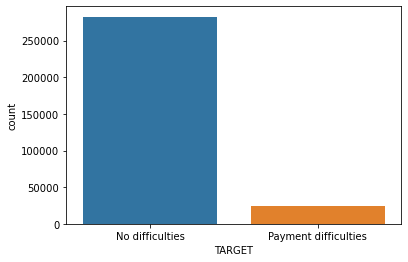

In [39]:
# visualize the target variable
g = sns.countplot(df['TARGET'])
g.set_xticklabels(['No difficulties','Payment difficulties'])
plt.show()

### Data cleaning

#### Infinity values

In [40]:
#Repérage des inf
np.isinf(df).values.sum()

21

In [41]:
#Remplacement des inf par NaN
df_inf = df.replace([np.inf, -np.inf], np.nan)
print(df.shape)
print(df_inf.shape)

(356251, 798)
(356251, 798)


#### Missing values

In [42]:
train_df_inf = df_inf[df_inf['TARGET'].notnull()]
test_df_inf = df_inf[df_inf['TARGET'].isnull()]

<AxesSubplot:>

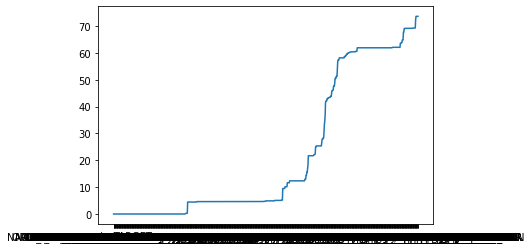

In [43]:
#Repérage des NaN
nan_values = train_df_inf.isna().sum().sort_values(ascending=True)
rate_nan_values = nan_values.sort_values(ascending=True)*100/(df.shape[0])
sns.lineplot(data=rate_nan_values)

In [44]:
rate_nan_values

index                                     0.000000
ORGANIZATION_TYPE_Security Ministries     0.000000
ORGANIZATION_TYPE_Self-employed           0.000000
ORGANIZATION_TYPE_Services                0.000000
ORGANIZATION_TYPE_Trade: type 1           0.000000
                                           ...    
REFUSED_RATE_DOWN_PAYMENT_MAX            73.638811
REFUSED_AMT_DOWN_PAYMENT_MIN             73.638811
REFUSED_AMT_DOWN_PAYMENT_MEAN            73.638811
REFUSED_RATE_DOWN_PAYMENT_MEAN           73.638811
REFUSED_AMT_DOWN_PAYMENT_MAX             73.638811
Length: 798, dtype: float64

In [45]:
type(rate_nan_values)

pandas.core.series.Series

In [46]:
rate_nan_values[rate_nan_values.index == 'EXT_SOURCE_3']

EXT_SOURCE_3    17.112934
dtype: float64

In [47]:
df_rate_nan_values= pd.DataFrame(rate_nan_values, columns=['rate_nan'])
df_rate_nan_values.index.name = 'feature'
df_rate_nan_values.reset_index(inplace=True)
df_rate_nan_values

,feature,rate_nan
0,index,0.000000
1,ORGANIZATION_TYPE_Security Ministries,0.000000
2,ORGANIZATION_TYPE_Self-employed,0.000000
3,ORGANIZATION_TYPE_Services,0.000000
4,ORGANIZATION_TYPE_Trade: type 1,0.000000
...,...,...
793,REFUSED_RATE_DOWN_PAYMENT_MAX,73.638811
794,REFUSED_AMT_DOWN_PAYMENT_MIN,73.638811
795,REFUSED_AMT_DOWN_PAYMENT_MEAN,73.638811
796,REFUSED_RATE_DOWN_PAYMENT_MEAN,73.638811


In [66]:
best_features_lgbmc = pd.read_csv('best_features.csv')
best_features_lgbmc 

,feature,importance
0,PAYMENT_RATE,1159.6
1,EXT_SOURCE_1,1044.7
2,EXT_SOURCE_3,1001.5
3,EXT_SOURCE_2,937.8
4,DAYS_BIRTH,765.3
5,AMT_ANNUITY,553.0
6,DAYS_EMPLOYED,546.6
7,DAYS_ID_PUBLISH,462.5
8,APPROVED_CNT_PAYMENT_MEAN,448.1
9,ACTIVE_DAYS_CREDIT_MAX,428.3


In [67]:
best_features_lgbmc_rate_nan = pd.merge(best_features_lgbmc, df_rate_nan_values)
best_features_lgbmc_rate_nan 

,feature,importance,rate_nan
0,PAYMENT_RATE,1159.6,0.003368
1,EXT_SOURCE_1,1044.7,48.666811
2,EXT_SOURCE_3,1001.5,17.112934
3,EXT_SOURCE_2,937.8,0.185263
4,DAYS_BIRTH,765.3,0.000000
5,AMT_ANNUITY,553.0,0.003368
6,DAYS_EMPLOYED,546.6,15.543535
7,DAYS_ID_PUBLISH,462.5,0.000000
8,APPROVED_CNT_PAYMENT_MEAN,448.1,4.897109
9,ACTIVE_DAYS_CREDIT_MAX,428.3,25.364420


In [ ]:
#Variables qu'on conserve même s'il y a un taux de NaN élévé car importantes
#best_features_lgbmc_NaN = ['']

In [ ]:
#On les exclus donc des variables potientellement supprimables
#exclude = df_inf.drop(best_features_lgbmc_NaN,1,inplace=True)
#nan_values = exclude.isna().sum().sort_values(ascending=True)
#rate_nan_values = nan_values.sort_values(ascending=True)*100/(df.shape[0])

In [48]:
print(train_df_inf.shape)

(307507, 798)


In [49]:
# Dropping features rate NaN >30%

# Divide in training/validation and test data
train_df_inf = df_inf[df_inf['TARGET'].notnull()]
test_df_inf = df_inf[df_inf['TARGET'].isnull()]

rate_nan_values = train_df_inf.isna().sum().sort_values(ascending=True)*100/(train_df_inf.shape[0])

#suppression colonnes avec plus de 30% de données manquantes
column_30nan = rate_nan_values[rate_nan_values > 30]
train_df30 = train_df_inf.drop(column_30nan.index,1)
#suppression des lignes avec données manquantes dans train_df
#index_with_nan = train_df30.index[train_df30.isnull().any(axis=1)]
#train_df30.drop(index_with_nan,0, inplace=True)

#test_df avec colonnes retenues
col = train_df30.columns
test_df30 =  test_df_inf[col]
test_df30.drop('TARGET',axis = 1, inplace=True)
#suppression des lignes avec données manquantes dans test_df
#index_with_nan = test_df30.index[test_df30.isnull().any(axis=1)]
#test_df30.drop(index_with_nan,0, inplace=True)
print(train_df30.shape)
print(test_df30.shape)

(307507, 545)
(48744, 544)


C:\Users\chiqu\anaconda3\lib\site-packages\pandas\core\frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [50]:
#suppression des lignes avec données manquantes dans train_df30

#train_df30 : train_df tq features avec plus de 30% NaN sont supprimées
index_with_nan = train_df30.index[train_df30.isnull().any(axis=1)]
train_df30r = train_df30.drop(index_with_nan,0)
print(train_df30r.shape)

#suppression des lignes avec données manquantes dans test_df
index_with_nan = test_df30.index[test_df30.isnull().any(axis=1)]
test_df30r = test_df30.drop(index_with_nan,0)
print(test_df30r.shape)
test_df30r.drop(['index'],axis=1,inplace=True)
test_df30r.to_csv('test_df30r.csv', index=False)

(102240, 545)
(17361, 544)


In [51]:
print(test_df30r.shape)

(17361, 543)


In [52]:
#On vérifie que les variables importantes sont tjrs là
#train_df30[best_features_lgbmc_NaN]

In [53]:
# Dropping features rate NaN >20%

#suppression colonnes avec plus de 20% de données manquantes
column_20nan = rate_nan_values[rate_nan_values > 20]
train_df20 = train_df_inf.drop(column_20nan.index,1)
#suppression des lignes avec données manquantes dans train_df
#index_with_nan = train_df20.index[train_df20.isnull().any(axis=1)]
#train_df20.drop(index_with_nan,0, inplace=True)

#test_df avec colonnes retenues
col = train_df20.columns
test_df20 =  test_df_inf[col]
test_df20.drop('TARGET',axis = 1, inplace=True)
#suppression des lignes avec données manquantes dans test_df
#index_with_nan = test_df20.index[test_df20.isnull().any(axis=1)]
#test_df20.drop(index_with_nan,0, inplace=True)
print(train_df20.shape)
print(test_df20.shape)

(307507, 509)
(48744, 508)


In [54]:
#suppression des lignes avec données manquantes dans train_df20

#train_df20 : train_df tq features avec plus de 20% NaN sont supprimées

index_with_nan = train_df20.index[train_df20.isnull().any(axis=1)]
train_df20r = train_df20.drop(index_with_nan,0)
print(train_df20r.shape)

#suppression des lignes avec données manquantes dans test_df
index_with_nan = test_df20.index[test_df20.isnull().any(axis=1)]
test_df20r = test_df20.drop(index_with_nan,0)
print(test_df20r.shape)

#On retire les colonnes  ['SK_ID_BUREAU','SK_ID_PREV','index']
test_df20r.drop(['index'],axis=1,inplace=True)
test_df20r.to_csv('test_df20r.csv', index=False)

(172764, 509)
(28861, 508)


In [55]:
print(test_df20r.shape)

(28861, 507)


In [56]:
test_df20r.columns

Index(['SK_ID_CURR', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY',
       'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
       'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE',
       ...
       'INSTAL_AMT_INSTALMENT_MEAN', 'INSTAL_AMT_INSTALMENT_SUM',
       'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_AMT_PAYMENT_MAX',
       'INSTAL_AMT_PAYMENT_MEAN', 'INSTAL_AMT_PAYMENT_SUM',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_COUNT'],
      dtype='object', length=507)

## Modelisation

### DummyClassifier

In [107]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
    
dummy = DummyClassifier(strategy = 'most_frequent')

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df[feats]
y = train_df['TARGET']


scores_dummy1 = cross_val_score(
    dummy, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_dummy1.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.500) total time=   0.9s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.0s remaining:    0.0s


[CV] END ................................ score: (test=0.500) total time=   0.7s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s


[CV] END ................................ score: (test=0.500) total time=   0.8s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    2.9s remaining:    0.0s


[CV] END ................................ score: (test=0.500) total time=   0.7s
[CV] END ................................ score: (test=0.500) total time=   0.7s
[CV] END ................................ score: (test=0.500) total time=   0.7s
[CV] END ................................ score: (test=0.500) total time=   0.7s
[CV] END ................................ score: (test=0.500) total time=   0.7s
[CV] END ................................ score: (test=0.500) total time=   0.7s
[CV] END ................................ score: (test=0.500) total time=   0.7s
0.5


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.4s finished


In [108]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

train_df = df[df['TARGET'].notnull()]
test_df = df[df['TARGET'].isnull()]
    
dummy = DummyClassifier(strategy = 'stratified')

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df[feats]
y = train_df['TARGET']


scores_dummy2 = cross_val_score(
    dummy, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_dummy2.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.499) total time=   1.0s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s


[CV] END ................................ score: (test=0.501) total time=   0.8s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.2s remaining:    0.0s


[CV] END ................................ score: (test=0.500) total time=   0.7s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.2s remaining:    0.0s


[CV] END ................................ score: (test=0.500) total time=   0.7s
[CV] END ................................ score: (test=0.497) total time=   0.7s
[CV] END ................................ score: (test=0.500) total time=   0.8s
[CV] END ................................ score: (test=0.501) total time=   0.7s
[CV] END ................................ score: (test=0.497) total time=   0.7s
[CV] END ................................ score: (test=0.504) total time=   0.7s
[CV] END ................................ score: (test=0.505) total time=   0.7s
0.5005924850819216


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.8s finished


### LightGBM

#### Without sampling

In [19]:
import re

# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

df_lgbmc= df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train_df_lgbmc = df_lgbmc[df_lgbmc['TARGET'].notnull()]
test_df_lgbmc = df_lgbmc[df_lgbmc['TARGET'].isnull()]

In [5]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve



cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df_lgbmc.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df_lgbmc[feats]
y = train_df_lgbmc['TARGET']



scores_lgbmc0 = cross_val_score(
    clf, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_lgbmc0.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.773) total time=16.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 16.6min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.777) total time=16.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 32.7min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.783) total time=16.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 48.7min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.783) total time=15.9min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.781) total time=16.1min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.785) total time=16.3min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.786) total time=16.3min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.781) total time=17.3min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.781) total time=16.8min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.776) total time=17.2min
0.7806552182381217


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 164.7min finished


In [7]:
from sklearn.model_selection import train_test_split

train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.30, random_state=0)


fit_params={'early_stopping_rounds': 200, 
            'eval_metric': 'auc',
            'verbose': 200,
            'eval_set': [(train_x, train_y),(val_x, val_y)]}

scores_lgbmc1  = cross_val_score(clf, train_x, train_y, 
                         cv = cv, 
                         scoring = 'roc_auc',
                         fit_params = fit_params)

print(scores_lgbmc1.mean())

C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.800385	valid_0's binary_logloss: 0.234227	valid_1's auc: 0.776399	valid_1's binary_logloss: 0.241713
[400]	valid_0's auc: 0.824681	valid_0's binary_logloss: 0.223843	valid_1's auc: 0.785381	valid_1's binary_logloss: 0.237875
[600]	valid_0's auc: 0.84109	valid_0's binary_logloss: 0.216971	valid_1's auc: 0.788278	valid_1's binary_logloss: 0.236768
[800]	valid_0's auc: 0.854068	valid_0's binary_logloss: 0.211389	valid_1's auc: 0.789381	valid_1's binary_logloss: 0.236331
[1000]	valid_0's auc: 0.865273	valid_0's binary_logloss: 0.206428	valid_1's auc: 0.789853	valid_1's binary_logloss: 0.236145
[1200]	valid_0's auc: 0.875154	valid_0's binary_logloss: 0.201826	valid_1's auc: 0.790173	valid_1's binary_logloss: 0.236053
[1400]	valid_0's auc: 0.884025	valid_0's binary_logloss: 0.19748	valid_1's auc: 0.79036	valid_1's binary_logloss: 0.236018


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.800655	valid_0's binary_logloss: 0.23413	valid_1's auc: 0.777166	valid_1's binary_logloss: 0.241587
[400]	valid_0's auc: 0.82499	valid_0's binary_logloss: 0.223747	valid_1's auc: 0.786362	valid_1's binary_logloss: 0.237705
[600]	valid_0's auc: 0.841294	valid_0's binary_logloss: 0.216921	valid_1's auc: 0.789327	valid_1's binary_logloss: 0.236535
[800]	valid_0's auc: 0.854288	valid_0's binary_logloss: 0.211425	valid_1's auc: 0.790435	valid_1's binary_logloss: 0.236093
[1000]	valid_0's auc: 0.86522	valid_0's binary_logloss: 0.206593	valid_1's auc: 0.790918	valid_1's binary_logloss: 0.2359
[1200]	valid_0's auc: 0.875024	valid_0's binary_logloss: 0.202044	valid_1's auc: 0.791217	valid_1's binary_logloss: 0.235805
[1400]	valid_0's auc: 0.883632	valid_0's binary_logloss: 0.197809	valid_1's auc: 0.791314	valid_1's binary_logloss: 0.235786


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.80048	valid_0's binary_logloss: 0.234257	valid_1's auc: 0.777189	valid_1's binary_logloss: 0.241714
[400]	valid_0's auc: 0.824914	valid_0's binary_logloss: 0.22384	valid_1's auc: 0.786662	valid_1's binary_logloss: 0.237671
[600]	valid_0's auc: 0.841201	valid_0's binary_logloss: 0.217062	valid_1's auc: 0.789584	valid_1's binary_logloss: 0.236522
[800]	valid_0's auc: 0.854391	valid_0's binary_logloss: 0.211453	valid_1's auc: 0.790577	valid_1's binary_logloss: 0.23612
[1000]	valid_0's auc: 0.865862	valid_0's binary_logloss: 0.206399	valid_1's auc: 0.791248	valid_1's binary_logloss: 0.235848
[1200]	valid_0's auc: 0.87587	valid_0's binary_logloss: 0.201713	valid_1's auc: 0.791528	valid_1's binary_logloss: 0.235734
[1400]	valid_0's auc: 0.884567	valid_0's binary_logloss: 0.197435	valid_1's auc: 0.791388	valid_1's binary_logloss: 0.235782


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.800292	valid_0's binary_logloss: 0.234245	valid_1's auc: 0.777229	valid_1's binary_logloss: 0.241555
[400]	valid_0's auc: 0.825131	valid_0's binary_logloss: 0.22375	valid_1's auc: 0.786303	valid_1's binary_logloss: 0.237714
[600]	valid_0's auc: 0.841939	valid_0's binary_logloss: 0.216732	valid_1's auc: 0.789089	valid_1's binary_logloss: 0.2366
[800]	valid_0's auc: 0.855245	valid_0's binary_logloss: 0.211057	valid_1's auc: 0.790165	valid_1's binary_logloss: 0.23618
[1000]	valid_0's auc: 0.866269	valid_0's binary_logloss: 0.206101	valid_1's auc: 0.790672	valid_1's binary_logloss: 0.235983
[1200]	valid_0's auc: 0.87631	valid_0's binary_logloss: 0.201435	valid_1's auc: 0.79098	valid_1's binary_logloss: 0.235876
[1400]	valid_0's auc: 0.885091	valid_0's binary_logloss: 0.197125	valid_1's auc: 0.791195	valid_1's binary_logloss: 0.23583


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.800942	valid_0's binary_logloss: 0.234144	valid_1's auc: 0.777468	valid_1's binary_logloss: 0.241525
[400]	valid_0's auc: 0.825171	valid_0's binary_logloss: 0.223791	valid_1's auc: 0.786479	valid_1's binary_logloss: 0.237644
[600]	valid_0's auc: 0.840689	valid_0's binary_logloss: 0.217164	valid_1's auc: 0.789457	valid_1's binary_logloss: 0.23649
[800]	valid_0's auc: 0.853638	valid_0's binary_logloss: 0.211576	valid_1's auc: 0.790536	valid_1's binary_logloss: 0.236042
[1000]	valid_0's auc: 0.864768	valid_0's binary_logloss: 0.206604	valid_1's auc: 0.791024	valid_1's binary_logloss: 0.235796
[1200]	valid_0's auc: 0.874613	valid_0's binary_logloss: 0.202032	valid_1's auc: 0.791258	valid_1's binary_logloss: 0.235715
[1400]	valid_0's auc: 0.88286	valid_0's binary_logloss: 0.197916	valid_1's auc: 0.791343	valid_1's binary_logloss: 0.235712


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.800623	valid_0's binary_logloss: 0.23422	valid_1's auc: 0.777698	valid_1's binary_logloss: 0.24153
[400]	valid_0's auc: 0.824995	valid_0's binary_logloss: 0.223773	valid_1's auc: 0.787129	valid_1's binary_logloss: 0.237508
[600]	valid_0's auc: 0.841145	valid_0's binary_logloss: 0.217091	valid_1's auc: 0.789668	valid_1's binary_logloss: 0.236382
[800]	valid_0's auc: 0.854277	valid_0's binary_logloss: 0.211486	valid_1's auc: 0.790852	valid_1's binary_logloss: 0.235893
[1000]	valid_0's auc: 0.865468	valid_0's binary_logloss: 0.20652	valid_1's auc: 0.791342	valid_1's binary_logloss: 0.235657
[1200]	valid_0's auc: 0.875213	valid_0's binary_logloss: 0.201958	valid_1's auc: 0.791308	valid_1's binary_logloss: 0.235612


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.800698	valid_0's binary_logloss: 0.234152	valid_1's auc: 0.776407	valid_1's binary_logloss: 0.241747
[400]	valid_0's auc: 0.82505	valid_0's binary_logloss: 0.223755	valid_1's auc: 0.785915	valid_1's binary_logloss: 0.2378
[600]	valid_0's auc: 0.84064	valid_0's binary_logloss: 0.217228	valid_1's auc: 0.788617	valid_1's binary_logloss: 0.236697
[800]	valid_0's auc: 0.853565	valid_0's binary_logloss: 0.211713	valid_1's auc: 0.789441	valid_1's binary_logloss: 0.236318
[1000]	valid_0's auc: 0.864444	valid_0's binary_logloss: 0.206902	valid_1's auc: 0.789749	valid_1's binary_logloss: 0.236191
[1200]	valid_0's auc: 0.874498	valid_0's binary_logloss: 0.202321	valid_1's auc: 0.789902	valid_1's binary_logloss: 0.236083
[1400]	valid_0's auc: 0.883657	valid_0's binary_logloss: 0.197931	valid_1's auc: 0.789873	valid_1's binary_logloss: 0.236086


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.80094	valid_0's binary_logloss: 0.234064	valid_1's auc: 0.777057	valid_1's binary_logloss: 0.24155
[400]	valid_0's auc: 0.82543	valid_0's binary_logloss: 0.223642	valid_1's auc: 0.786237	valid_1's binary_logloss: 0.237637
[600]	valid_0's auc: 0.841527	valid_0's binary_logloss: 0.216911	valid_1's auc: 0.78888	valid_1's binary_logloss: 0.236543
[800]	valid_0's auc: 0.854548	valid_0's binary_logloss: 0.211321	valid_1's auc: 0.789785	valid_1's binary_logloss: 0.236183
[1000]	valid_0's auc: 0.865555	valid_0's binary_logloss: 0.206487	valid_1's auc: 0.790339	valid_1's binary_logloss: 0.235969
[1200]	valid_0's auc: 0.875187	valid_0's binary_logloss: 0.202061	valid_1's auc: 0.790578	valid_1's binary_logloss: 0.235893
[1400]	valid_0's auc: 0.884101	valid_0's binary_logloss: 0.197742	valid_1's auc: 0.790731	valid_1's binary_logloss: 0.235851
[1600]	valid_0's auc

C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.800766	valid_0's binary_logloss: 0.234051	valid_1's auc: 0.776773	valid_1's binary_logloss: 0.241701
[400]	valid_0's auc: 0.825195	valid_0's binary_logloss: 0.22369	valid_1's auc: 0.7861	valid_1's binary_logloss: 0.237819
[600]	valid_0's auc: 0.841488	valid_0's binary_logloss: 0.216837	valid_1's auc: 0.788858	valid_1's binary_logloss: 0.236723
[800]	valid_0's auc: 0.854818	valid_0's binary_logloss: 0.211208	valid_1's auc: 0.790436	valid_1's binary_logloss: 0.236165
[1000]	valid_0's auc: 0.866177	valid_0's binary_logloss: 0.206234	valid_1's auc: 0.790884	valid_1's binary_logloss: 0.236013
[1200]	valid_0's auc: 0.876079	valid_0's binary_logloss: 0.201644	valid_1's auc: 0.791278	valid_1's binary_logloss: 0.235865
[1400]	valid_0's auc: 0.884731	valid_0's binary_logloss: 0.197421	valid_1's auc: 0.791398	valid_1's binary_logloss: 0.235839


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	valid_0's auc: 0.80074	valid_0's binary_logloss: 0.234136	valid_1's auc: 0.776363	valid_1's binary_logloss: 0.241783
[400]	valid_0's auc: 0.825	valid_0's binary_logloss: 0.223809	valid_1's auc: 0.785569	valid_1's binary_logloss: 0.237866
[600]	valid_0's auc: 0.840863	valid_0's binary_logloss: 0.217182	valid_1's auc: 0.788374	valid_1's binary_logloss: 0.236715
[800]	valid_0's auc: 0.854062	valid_0's binary_logloss: 0.211545	valid_1's auc: 0.7894	valid_1's binary_logloss: 0.236305
[1000]	valid_0's auc: 0.865327	valid_0's binary_logloss: 0.206599	valid_1's auc: 0.789899	valid_1's binary_logloss: 0.23611
[1200]	valid_0's auc: 0.875065	valid_0's binary_logloss: 0.201999	valid_1's auc: 0.790119	valid_1's binary_logloss: 0.236014
[1400]	valid_0's auc: 0.884231	valid_0's binary_logloss: 0.197587	valid_1's auc: 0.790415	valid_1's binary_logloss: 0.235916
[1600]	valid_0's auc: 0

In [104]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve


train_df20r_lgbmc = train_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df20r_lgbmc.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r_lgbmc[feats]
y = train_df20r_lgbmc['TARGET']



scores_lgbmc20r = cross_val_score(
    clf, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_lgbmc20r.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.757) total time= 4.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.6min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.763) total time= 4.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  9.3min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.762) total time= 4.7min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 14.0min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.753) total time= 4.7min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.753) total time= 4.6min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.765) total time= 4.6min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.767) total time= 4.6min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.760) total time= 4.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.755) total time= 4.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.751) total time= 4.4min
0.7586108250636592


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 45.7min finished


In [106]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve


train_df30r_lgbmc = train_df30r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df30r_lgbmc.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df30r_lgbmc[feats]
y = train_df30r_lgbmc['TARGET']



scores_lgbmc30r = cross_val_score(
    clf, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_lgbmc30r.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.741) total time= 3.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.741) total time= 3.3min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.6min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.745) total time= 3.2min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.7min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.748) total time= 3.3min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.738) total time= 3.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.755) total time= 3.2min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.756) total time= 3.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.747) total time= 3.3min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.742) total time= 3.4min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.746) total time= 3.3min
0.7459600396329262


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 33.0min finished


#### With sampling : SMOTEENN

In [24]:
#Traitement NaN nécessaire pour l'utilisation de SMOTEENN


#Traitement données manquantes

# Divide in training/validation and test data 
train_df_lgbmcNaN = train_df_lgbmc
test_df_lgbmcNaN = test_df_lgbmc
#suppression colonnes avec plus de 30% de données manquantes
column_with_nan = train_df_lgbmcNaN.columns[train_df_lgbmcNaN.isnull().any()]
for column in column_with_nan:
    if train_df_lgbmcNaN[column].isnull().sum()*100.0/train_df_lgbmcNaN.shape[0] > 30:
        train_df_lgbmcNaN.drop(column,1, inplace=True)
#suppression des lignes avec données manquantes dans train_df_lgbmcNaN
index_with_nan = train_df_lgbmcNaN.index[train_df_lgbmcNaN.isnull().any(axis=1)]
train_df_lgbmcNaN.drop(index_with_nan,0, inplace=True)
#test_df_lgbmcNaN avec colonnes retenues
col = train_df_lgbmcNaN.columns
test_df_lgbmcNaN =  test_df_lgbmcNaN[col]
test_df_lgbmcNaN.drop('TARGET',axis = 1, inplace=True)
#suppression des lignes avec données manquantes dans test_df_lgbmcNaN
index_with_nan = test_df_lgbmcNaN.index[test_df_lgbmcNaN.isnull().any(axis=1)]
test_df_lgbmcNaN.drop(index_with_nan,0, inplace=True)

feats = [f for f in train_df_lgbmcNaN.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df_lgbmcNaN[feats]
y = train_df_lgbmcNaN['TARGET']

In [25]:
categorical_list = []
float_list = []
int_list = []

for i in train_df_lgbmcNaN.columns.tolist():
    if train_df_lgbmcNaN[i].dtype=='uint8':
        categorical_list.append(i)
    elif train_df_lgbmcNaN[i].dtype=='float64':
        float_list.append(i)
    else:
        int_list.append(i)
cat_features = categorical_list + ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']
del int_list[0:5]
del float_list[0]
num_features = float_list + int_list
print('Number of categorical features:', str(len(cat_features)))
print('Number of numerical features:', str(len(num_features)))
print('Number of float features:', str(len(float_list)))
print('Number of int features:', str(len(int_list)))

Number of categorical features: 136
Number of numerical features: 406
Number of float features: 368
Number of int features: 38


In [21]:
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE 
from imblearn.combine import SMOTEENN

smoteenn = SMOTEENN(random_state=0) 

preprocessor_lgbmcNaN = ColumnTransformer(
    transformers=[('scaler', StandardScaler(), float_list)],
    remainder='passthrough')

model_pipeline = Pipeline_imb(steps=[
                      ('preprocessor', preprocessor_lgbmcNaN),
                      ('sampling',smoteenn),
                      ('classifier', clf)])

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)


scores_lgbmc_pip3 = cross_val_score(
    model_pipeline, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_lgbmc_pip3.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.745) total time=10.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.6min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.754) total time=10.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 21.3min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.750) total time=10.8min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 32.1min remaining:    0.0s
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.755) total time=10.6min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.746) total time=10.7min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.758) total time=10.6min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.759) total time=10.6min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.750) total time=10.7min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.749) total time=10.9min


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[CV] END ................................ score: (test=0.748) total time=10.7min
0.7514263066623406


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 106.9min finished


### RandomForestClassifier

#### Default parameters 

##### Dropping features with more than 20% missing values

In [109]:
#Suppression features avec plus de 20% NaN et suppression lignes NaN

from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0)
cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

scores_rfc20r = cross_val_score(
    rfc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_rfc20r.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.717) total time= 2.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s


[CV] END ................................ score: (test=0.703) total time= 2.9min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.7min remaining:    0.0s


[CV] END ................................ score: (test=0.714) total time= 2.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.6min remaining:    0.0s


[CV] END ................................ score: (test=0.696) total time= 2.9min
[CV] END ................................ score: (test=0.719) total time= 2.9min
[CV] END ................................ score: (test=0.702) total time= 2.9min
[CV] END ................................ score: (test=0.709) total time= 2.9min
[CV] END ................................ score: (test=0.718) total time= 2.8min
[CV] END ................................ score: (test=0.720) total time= 2.8min
[CV] END ................................ score: (test=0.704) total time= 2.8min
0.7101512331585695


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 28.7min finished


##### Dropping features with more than 30% missing values

In [28]:
#Suppression features avec plus de 30% NaN et suppression lignes NaN

from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score


rfc = RandomForestClassifier(random_state=0)
cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)    
#train_df = df[df['TARGET'].notnull()]
#test_df = df[df['TARGET'].isnull()]

#suppression colonnes avec plus de 30% de données manquantes
#column_with_nan = train_df.columns[train_df.isnull().any()]
#for column in column_with_nan:
#    if train_df[column].isnull().sum()*100.0/train_df.shape[0] > 30:
#        train_df.drop(column,1, inplace=True)


feats = [f for f in train_df30r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df30r[feats]
y = train_df30r['TARGET']

scores_rfc30r = cross_val_score(
    rfc, X, y, cv=cv, scoring='roc_auc', verbose=4
)


print(scores_rfc30r.mean())

(102240, 545)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.683) total time= 1.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.6min remaining:    0.0s


[CV] END ................................ score: (test=0.688) total time= 1.6min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.2min remaining:    0.0s


[CV] END ................................ score: (test=0.702) total time= 1.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.8min remaining:    0.0s


[CV] END ................................ score: (test=0.680) total time= 1.6min
[CV] END ................................ score: (test=0.696) total time= 1.6min
[CV] END ................................ score: (test=0.703) total time= 1.5min
[CV] END ................................ score: (test=0.697) total time= 1.6min
[CV] END ................................ score: (test=0.694) total time= 1.6min
[CV] END ................................ score: (test=0.697) total time= 1.6min
[CV] END ................................ score: (test=0.698) total time= 1.6min
0.6938453525415655


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 15.9min finished


#### Default parameters and class_weight='balanced'

##### Dropping features with more than 20% missing values

In [30]:
#Suppression features avec plus de 20% NaN et suppression lignes NaN

from sklearn.ensemble import RandomForestClassifier

rfc_bal = RandomForestClassifier(random_state=0, class_weight='balanced')
    
index_with_nan = train_df20.index[train_df20.isnull().any(axis=1)]
train_df20r = train_df20.drop(index_with_nan,0)
print(train_df20r.shape)

#train_df20r = train_df tq features avec plus de 20% NaN sont supprimées et lignes NaN supprimées
feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

scores_rfc_bal20r = cross_val_score(
    rfc_bal, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_rfc_bal20r.mean())

(172764, 509)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.728) total time= 1.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


[CV] END ................................ score: (test=0.721) total time= 1.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min remaining:    0.0s


[CV] END ................................ score: (test=0.723) total time= 1.7min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  5.0min remaining:    0.0s


[CV] END ................................ score: (test=0.712) total time= 1.7min
[CV] END ................................ score: (test=0.728) total time= 1.7min
[CV] END ................................ score: (test=0.718) total time= 1.9min
[CV] END ................................ score: (test=0.729) total time= 1.8min
[CV] END ................................ score: (test=0.731) total time= 1.8min
[CV] END ................................ score: (test=0.721) total time= 1.8min
[CV] END ................................ score: (test=0.718) total time= 1.8min
0.7229504009259903


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 17.6min finished


##### Dropping features with more than 30% missing values

In [31]:
#Suppression features avec plus de 30% NaN et suppression lignes NaN

from sklearn.ensemble import RandomForestClassifier

rfc_bal = RandomForestClassifier(random_state=0, class_weight='balanced')
    
index_with_nan = train_df30.index[train_df30.isnull().any(axis=1)]
train_df30r = train_df30.drop(index_with_nan,0)
print(train_df30r.shape)

#train_df30r = train_df tq features avec plus de 30% NaN sont supprimées et lignes NaN supprimées
feats = [f for f in train_df30r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df30r[feats]
y = train_df30r['TARGET']

scores_rfc_bal30r = cross_val_score(
    rfc_bal, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_rfc_bal30r.mean())

(102240, 545)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.710) total time= 1.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] END ................................ score: (test=0.707) total time= 1.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.1min remaining:    0.0s


[CV] END ................................ score: (test=0.713) total time= 1.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  3.2min remaining:    0.0s


[CV] END ................................ score: (test=0.711) total time= 1.1min
[CV] END ................................ score: (test=0.699) total time= 1.1min
[CV] END ................................ score: (test=0.719) total time= 1.1min
[CV] END ................................ score: (test=0.709) total time= 1.1min
[CV] END ................................ score: (test=0.703) total time= 1.1min
[CV] END ................................ score: (test=0.713) total time= 1.1min
[CV] END ................................ score: (test=0.700) total time= 1.1min
0.7085201645119301


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 10.7min finished


#### Hyperparameters search

In [51]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3,
                                                    random_state=0)

rfc = RandomForestClassifier(random_state=0, class_weight='balanced')


import timeit
start_time = timeit.default_timer()


param_grid = {'max_depth' : [8,9,10], 'n_estimators' : [400, 500, 1000, 2000]}
  

cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1001)

# Créer un classifieur avec recherche d'hyperparamètre par validation croisée
grid = model_selection.GridSearchCV(
                                  rfc,   # un classifieur pipeline
                                  param_grid,           # hyperparamètres à tester
                                  cv=cv,             # nombre de folds de validation croisée
                                  scoring='roc_auc',# score à maximiser
                                  verbose=4
                                    )


grid.fit(X_train, y_train)



# afficher les paramètres optimaux
print("The optimal parameters are {} with a roc_auc_score of {:.3f}".format(grid.best_params_, grid.best_score_))

elapsed = timeit.default_timer() - start_time
print('time: %f' % elapsed)

y_pred = grid.predict(X_test)

print("\nSur le jeu de test roc_auc_score : {:.3f}".format(metrics.roc_auc_score(y_test, y_pred)))

roc_auc_score = metrics.roc_auc_score(y_test, y_pred)
print('roc_auc_score: %f' % roc_auc_score) 

accuracy_score = metrics.accuracy_score(y_test, y_pred)
print('accuracy_score: %f' % accuracy_score)

log_loss = metrics.log_loss(y_test, y_pred)
print('log_loss: %f' % log_loss)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .....max_depth=8, n_estimators=400;, score=0.732 total time= 2.5min
[CV 2/5] END .....max_depth=8, n_estimators=400;, score=0.737 total time= 2.4min
[CV 3/5] END .....max_depth=8, n_estimators=400;, score=0.746 total time= 2.0min
[CV 4/5] END .....max_depth=8, n_estimators=400;, score=0.745 total time= 1.9min
[CV 5/5] END .....max_depth=8, n_estimators=400;, score=0.738 total time= 1.9min
[CV 1/5] END .....max_depth=8, n_estimators=500;, score=0.732 total time= 2.4min
[CV 2/5] END .....max_depth=8, n_estimators=500;, score=0.737 total time= 2.4min
[CV 3/5] END .....max_depth=8, n_estimators=500;, score=0.746 total time= 2.4min
[CV 4/5] END .....max_depth=8, n_estimators=500;, score=0.745 total time= 2.4min
[CV 5/5] END .....max_depth=8, n_estimators=500;, score=0.738 total time= 2.4min
[CV 1/5] END ....max_depth=8, n_estimators=1000;, score=0.731 total time= 4.7min
[CV 2/5] END ....max_depth=8, n_estimators=1000;

NameError: name 'metrics' is not defined

In [53]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report


feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']


X_train, X_test, y_train, y_test = model_selection.train_test_split(train_df20r[feats], train_df20r['TARGET'], test_size=0.3,
                                                    random_state=0)



import timeit
start_time = timeit.default_timer()

rfc = RandomForestClassifier(random_state=0)

smoteenn = SMOTEENN(random_state=0)

preprocessor = ColumnTransformer(transformers=[
              ('scaler', StandardScaler(), float_features20)
              ],remainder='passthrough')


model_pipeline = Pipeline_imb(steps=[
                      ('sampling',smoteenn),
                      ('preprocessor', preprocessor),
                      ('classifier', rfc)
                   ])


param_grid = [
  
    {   'sampling__sampling_strategy' : [0.2,0.3],
        'classifier__max_depth' : [8,9],
        'classifier__n_estimators' : [400,500]
    },
    
]

# define evaluation procedure
cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1001)

# Créer un classifieur avec recherche d'hyperparamètre par validation croisée
grid = model_selection.GridSearchCV(
                                  model_pipeline,   # un classifieur pipeline
                                  param_grid,           # hyperparamètres à tester
                                  cv=cv,             # nombre de folds de validation croisée
                                  scoring='roc_auc',# score à maximiser
                                  verbose=4
                                    )


grid.fit(X_train, y_train)



# afficher les paramètres optimaux
print("The optimal parameters are {} with a roc_auc_score of {:.3f}".format(grid.best_params_, grid.best_score_))

elapsed = timeit.default_timer() - start_time
print('time: %f' % elapsed)

y_pred = grid.predict(X_test)

print("\nSur le jeu de test roc_auc_score : {:.3f}".format(metrics.roc_auc_score(y_test, y_pred)))

roc_auc_score = metrics.roc_auc_score(y_test, y_pred)
print('roc_auc_score: %f' % roc_auc_score) 

accuracy_score = metrics.accuracy_score(y_test, y_pred)
print('accuracy_score: %f' % accuracy_score)

log_loss = metrics.log_loss(y_test, y_pred)
print('log_loss: %f' % log_loss)


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END classifier__max_depth=8, classifier__n_estimators=400, sampling__sampling_strategy=0.2;, score=0.705 total time= 2.8min
[CV 2/5] END classifier__max_depth=8, classifier__n_estimators=400, sampling__sampling_strategy=0.2;, score=0.713 total time= 2.8min
[CV 3/5] END classifier__max_depth=8, classifier__n_estimators=400, sampling__sampling_strategy=0.2;, score=0.720 total time= 2.9min
[CV 4/5] END classifier__max_depth=8, classifier__n_estimators=400, sampling__sampling_strategy=0.2;, score=0.717 total time= 2.9min
[CV 5/5] END classifier__max_depth=8, classifier__n_estimators=400, sampling__sampling_strategy=0.2;, score=0.712 total time= 2.7min
[CV 1/5] END classifier__max_depth=8, classifier__n_estimators=400, sampling__sampling_strategy=0.3;, score=0.706 total time= 3.2min
[CV 2/5] END classifier__max_depth=8, classifier__n_estimators=400, sampling__sampling_strategy=0.3;, score=0.708 total time= 3.3min
[CV 3/5] 

NameError: name 'metrics' is not defined

#### Best parameters and class_weight='balanced'

##### Dropping features with more than 20% missing values

###### Dropping rows with missing values

In [32]:
#Suppression features avec plus de 20% NaN et suppression lignes NaN

from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0, n_estimators=400, max_depth= 8, class_weight='balanced')
    
#train_df20r = train_df tq features avec plus de 20% NaN sont supprimées et lignes NaN supprimées
feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

scores_rfc_mp20 = cross_val_score(
    rfc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_rfc_mp20.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.744) total time= 3.3min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.3min remaining:    0.0s


[CV] END ................................ score: (test=0.740) total time= 3.2min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.5min remaining:    0.0s


[CV] END ................................ score: (test=0.747) total time= 3.3min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.8min remaining:    0.0s


[CV] END ................................ score: (test=0.731) total time= 3.2min
[CV] END ................................ score: (test=0.744) total time= 3.3min
[CV] END ................................ score: (test=0.740) total time= 3.2min
[CV] END ................................ score: (test=0.746) total time= 3.2min
[CV] END ................................ score: (test=0.745) total time= 3.2min
[CV] END ................................ score: (test=0.733) total time= 3.2min
[CV] END ................................ score: (test=0.734) total time= 3.2min
0.7404618437327944


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 32.3min finished


###### Imputing rows with missing values

In [ ]:
#Missing values in categorical features : no
#Missing values in integer features : no
#Missing values in float features : ok

In [20]:
categorical_feature_mask20 = train_df20.dtypes=='uint8'
categorical_features20 = train_df20.columns[categorical_feature_mask20].tolist()
categorical_features20 = categorical_features20 + ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

float_feature_mask20 = train_df20.dtypes=='float64'
float_features20 = train_df20.columns[float_feature_mask20].tolist()
del float_features20[0]

integer_feature_mask20 = train_df20.dtypes=='int64'
integer_features20 = train_df20.columns[integer_feature_mask20].tolist()
del integer_features20[0:5]

In [16]:
from sklearn.pipeline import Pipeline


categorical_transformer = Pipeline(steps=[
    ('imputerc', SimpleImputer(strategy='most_frequent')),
])

numeric_transformer = Pipeline(steps=[
    ('imputerf', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])


from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, float_features20),
        ('cat', categorical_transformer, categorical_features20)
    ]
)

In [17]:
#Suppression features avec plus de 20% NaN et Impute lignes NaN

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler



from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve



cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)


rfc = RandomForestClassifier(random_state=0, n_estimators=400, max_depth= 8, class_weight='balanced')

#train_df20 = train_df tq features avec plus de 20% NaN sont supprimées 
feats = [f for f in train_df20.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20[feats]
y = train_df20['TARGET']




pipeline_modele = Pipeline([
     ('preprocessor', preprocessor),
     ('rfc', rfc)
])




impute_scores_rfc20 = cross_val_score(
        pipeline_modele, X, y, cv=cv, scoring='roc_auc', error_score='raise', verbose=4
)
        
print(impute_scores_rfc20.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.738) total time= 7.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.7min remaining:    0.0s


[CV] END ................................ score: (test=0.737) total time= 7.6min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 15.3min remaining:    0.0s


[CV] END ................................ score: (test=0.736) total time= 7.6min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 22.9min remaining:    0.0s


[CV] END ................................ score: (test=0.741) total time= 7.8min
[CV] END ................................ score: (test=0.741) total time= 7.7min
[CV] END ................................ score: (test=0.742) total time= 7.7min
[CV] END ................................ score: (test=0.738) total time= 7.7min


KeyboardInterrupt: 

##### Dropping features with more than 30% missing values

###### Dropping rows with missing values

In [33]:
#Suppression features avec plus de 30% NaN et suppression lignes NaN
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=0, n_estimators=400, max_depth= 8, class_weight='balanced')
    
#train_df30r = train_df tq features avec plus de 30% NaN sont supprimées et lignes NaN supprimées
feats = [f for f in train_df30r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df30r[feats]
y = train_df30r['TARGET']

scores_rfc_mp30 = cross_val_score(
    rfc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_rfc_mp30.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.737) total time= 2.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.1min remaining:    0.0s


[CV] END ................................ score: (test=0.732) total time= 2.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  4.2min remaining:    0.0s


[CV] END ................................ score: (test=0.735) total time= 2.1min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  6.2min remaining:    0.0s


[CV] END ................................ score: (test=0.729) total time= 2.1min
[CV] END ................................ score: (test=0.729) total time= 2.1min
[CV] END ................................ score: (test=0.746) total time= 2.1min
[CV] END ................................ score: (test=0.732) total time= 2.1min
[CV] END ................................ score: (test=0.735) total time= 2.1min
[CV] END ................................ score: (test=0.732) total time= 2.1min
[CV] END ................................ score: (test=0.731) total time= 2.1min
0.7338891109793184


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 20.8min finished


###### Imputing rows with missing values

In [ ]:
#Suppression features avec plus de 30% NaN et imputation lignes NaN

In [19]:
categorical_feature_mask30 = train_df30.dtypes=='uint8'
categorical_features30 = train_df30.columns[categorical_feature_mask30].tolist()
categorical_features30 = categorical_features30 + ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

float_feature_mask30 = train_df30.dtypes=='float64'
float_features30 = train_df30.columns[float_feature_mask30].tolist()
del float_features30[0]

integer_feature_mask30 = train_df30.dtypes=='int64'
integer_features30 = train_df30.columns[integer_feature_mask30].tolist()
del integer_features30[0:5]

In [92]:
from sklearn.pipeline import Pipeline


categorical_transformer = Pipeline(steps=[
    ('imputerc', SimpleImputer(strategy='most_frequent')),
])

numeric_transformer = Pipeline(steps=[
    ('imputerf', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])


from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, float_features30),
        ('cat', categorical_transformer, categorical_features30)
    ]
)

In [93]:
#Suppression features avec plus de 30% NaN et Impute lignes NaN

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler



from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve



cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)


rfc = RandomForestClassifier(random_state=0, n_estimators=400, max_depth= 8, class_weight='balanced')

#train_df30 = train_df tq features avec plus de 30% NaN sont supprimées 
feats = [f for f in train_df30.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df30[feats]
y = train_df30['TARGET']




pipeline_modele = Pipeline([
     ('preprocessor', preprocessor),
     ('rfc', rfc)
])




impute_scores_rfc30 = cross_val_score(
        pipeline_modele, X, y, cv=cv, scoring='roc_auc', error_score='raise', verbose=4
)
        
print(impute_scores_rfc30.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.735) total time= 6.2min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.2min remaining:    0.0s


[CV] END ................................ score: (test=0.734) total time= 6.1min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 12.3min remaining:    0.0s


[CV] END ................................ score: (test=0.733) total time= 6.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 18.3min remaining:    0.0s


[CV] END ................................ score: (test=0.737) total time= 6.0min
[CV] END ................................ score: (test=0.738) total time= 6.0min
[CV] END ................................ score: (test=0.738) total time= 6.0min
[CV] END ................................ score: (test=0.736) total time= 6.2min
[CV] END ................................ score: (test=0.743) total time= 6.2min
[CV] END ................................ score: (test=0.734) total time= 6.2min
[CV] END ................................ score: (test=0.739) total time= 6.1min
0.7367927498448632


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 61.1min finished


##### No Dropping features : imputation of all missing values

In [ ]:
#Tout Impute

In [100]:
categorical_feature_maskinf = train_df_inf.dtypes=='uint8'
categorical_featuresinf = train_df_inf.columns[categorical_feature_maskinf].tolist()
categorical_featuresinf = categorical_featuresinf + ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

float_feature_maskinf = train_df_inf.dtypes=='float64'
float_featuresinf = train_df_inf.columns[float_feature_maskinf].tolist()
del float_featuresinf[0]

integer_feature_maskinf = train_df_inf.dtypes=='int64'
integer_featuresinf = train_df_inf.columns[integer_feature_maskinf].tolist()
del integer_featuresinf[0:5]

In [101]:
from sklearn.pipeline import Pipeline


categorical_transformer = Pipeline(steps=[
    ('imputerc', SimpleImputer(strategy='most_frequent')),
])

numeric_transformer = Pipeline(steps=[
    ('imputerf', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])


from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, float_featuresinf),
        ('cat', categorical_transformer, categorical_featuresinf)
    ]
)

In [102]:
#Tout Impute

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler



from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve



cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)


rfc = RandomForestClassifier(random_state=0, n_estimators=400, max_depth= 8, class_weight='balanced')

#train_df_inf = train_df tq infinity values are replaced by NaN
feats = [f for f in train_df_inf.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df_inf[feats]
y = train_df_inf['TARGET']




pipeline_modele = Pipeline([
     ('preprocessor', preprocessor),
     ('rfc', rfc)
])




impute_scores_rfcinf = cross_val_score(
        pipeline_modele, X, y, cv=cv, scoring='roc_auc', error_score='raise', verbose=4
)
        
print(impute_scores_rfcinf.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.739) total time= 6.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.9min remaining:    0.0s


[CV] END ................................ score: (test=0.740) total time= 6.9min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.8min remaining:    0.0s


[CV] END ................................ score: (test=0.739) total time= 6.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 20.7min remaining:    0.0s


[CV] END ................................ score: (test=0.742) total time= 6.9min
[CV] END ................................ score: (test=0.743) total time= 6.9min
[CV] END ................................ score: (test=0.744) total time= 6.8min
[CV] END ................................ score: (test=0.741) total time= 6.8min
[CV] END ................................ score: (test=0.748) total time= 6.8min
[CV] END ................................ score: (test=0.739) total time= 6.9min
[CV] END ................................ score: (test=0.744) total time= 6.9min
0.741743825148913


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 68.7min finished


#### Best parameters and sampling (Smoteenn)

##### Dropping features with more 30% missing values

In [17]:
from sklearn.pipeline import Pipeline


#categorical_transformer = Pipeline(steps=[
#    ('imputerc', SimpleImputer(strategy='most_frequent')),
#])

numeric_transformer = Pipeline(steps=[
    ('imputerf', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])


from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, float_features30),
#        ('cat', categorical_transformer, categorical_featuresinf)
    ]
)

In [20]:
#Suppression features avec plus de 30% NaN et Impute lignes NaN et smoteenn

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE 
from imblearn.combine import SMOTEENN

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

rfc = RandomForestClassifier(random_state=0, n_estimators=400, max_depth= 8)

#train_df30 = train_df tq features avec plus de 30% NaN sont supprimées 
feats = [f for f in train_df30.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df30[feats]
y = train_df30['TARGET']

smoteenn = SMOTEENN(random_state=0) 


model_pipeline = Pipeline_imb(steps=[
                      ('preprocessor', preprocessor),
                      ('sampling',smoteenn),
                      ('classifier', rfc)])
    
impute_scores_rfc30_smoteenn = cross_val_score(
        model_pipeline, X, y, cv=cv, scoring='roc_auc', error_score='raise', verbose=4
)
        
print(impute_scores_rfc30_smoteenn.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.680) total time=35.4min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 35.4min remaining:    0.0s


[CV] END ................................ score: (test=0.676) total time=35.7min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 71.1min remaining:    0.0s


KeyboardInterrupt: 

##### Dropping features with more 20% missing values

In [22]:
from sklearn.pipeline import Pipeline


#categorical_transformer = Pipeline(steps=[
#    ('imputerc', SimpleImputer(strategy='most_frequent')),
#])

numeric_transformer = Pipeline(steps=[
#    ('imputerf', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])


from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, float_features20),
#        ('cat', categorical_transformer, categorical_featuresinf)
    ]
)

In [23]:
#Suppression features avec plus de 20% NaN et suppression lignes NaN et smoteenn

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE 
from imblearn.combine import SMOTEENN

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

rfc = RandomForestClassifier(random_state=0, n_estimators=400, max_depth= 8)

#train_df20 : train_df tq features avec plus de 20% NaN sont supprimées
#suppression des lignes avec données manquantes dans train_df20
index_with_nan = train_df20.index[train_df20.isnull().any(axis=1)]
train_df20r = train_df20.drop(index_with_nan,0)
print(train_df20r.shape)

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

smoteenn = SMOTEENN(random_state=0) 


model_pipeline = Pipeline_imb(steps=[
                      ('preprocessor', preprocessor),
                      ('sampling',smoteenn),
                      ('classifier', rfc)])
    
impute_scores_rfc20_smoteenn = cross_val_score(
        model_pipeline, X, y, cv=cv, scoring='roc_auc', error_score='raise', verbose=4
)
        
print(impute_scores_rfc20_smoteenn.mean())

(172764, 509)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.691) total time=11.8min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.8min remaining:    0.0s


[CV] END ................................ score: (test=0.685) total time=11.9min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 23.7min remaining:    0.0s


[CV] END ................................ score: (test=0.673) total time=12.0min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 35.7min remaining:    0.0s


[CV] END ................................ score: (test=0.679) total time=11.7min
[CV] END ................................ score: (test=0.681) total time=11.6min
[CV] END ................................ score: (test=0.680) total time=12.0min
[CV] END ................................ score: (test=0.688) total time=12.0min
[CV] END ................................ score: (test=0.682) total time=12.1min
[CV] END ................................ score: (test=0.676) total time=11.9min
[CV] END ................................ score: (test=0.681) total time=12.1min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 119.1min finished


NameError: name 'impute_scores_rfc20_smoteenn' is not defined

In [24]:
print(impute_scores_rfc30_smoteenn.mean())

0.6815835844245774


#### Best parameters and sampling (Smote)

In [ ]:
#Suppression features avec plus de 20% NaN et suppression lignes NaN et smote

from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.pipeline import Pipeline as Pipeline_imb
from sklearn import model_selection
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE, SMOTENC, BorderlineSMOTE 
from imblearn.combine import SMOTEENN

from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

rfc = RandomForestClassifier(random_state=0, n_estimators=400, max_depth= 8)

#train_df20 : train_df tq features avec plus de 20% NaN sont supprimées
#suppression des lignes avec données manquantes dans train_df20
index_with_nan = train_df20.index[train_df20.isnull().any(axis=1)]
train_df20r = train_df20.drop(index_with_nan,0)
print(train_df20r.shape)

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

smote = SMOTE(random_state=0) 


model_pipeline = Pipeline_imb(steps=[
                      ('preprocessor', preprocessor),
                      ('sampling',smoteenn),
                      ('classifier', rfc)])
    
impute_scores_rfc20_smote = cross_val_score(
        model_pipeline, X, y, cv=cv, scoring='roc_auc', error_score='raise', verbose=4
)
        
print(impute_scores_rfc20_smote.mean())

### XGboost

In [40]:
#!pip install xgboost

#### Default parameters

In [43]:
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score


#df_lgbmc= df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
train_df_inf = df_inf[df_inf['TARGET'].notnull()]
test_df_inf = df_inf[df_inf['TARGET'].isnull()]

feats = [f for f in train_df_inf.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df_inf[feats]
y = train_df_inf['TARGET']

xgbc = XGBClassifier()

train_x, val_x, train_y, val_y = train_test_split(X, y, test_size = 0.30, random_state=0)

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)


fit_params={'early_stopping_rounds': 200, 
            'eval_metric': 'auc',
            'verbose': 200,
            'eval_set': [(train_x, train_y),(val_x, val_y)]}

scores_xgbc0  = cross_val_score(xgbc, train_x, train_y, 
                         cv = cv, 
                         scoring = 'roc_auc',
                         fit_params = fit_params)

print(scores_xgbc0.mean())

C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71588	validation_1-auc:0.70762
[99]	validation_0-auc:0.90120	validation_1-auc:0.77370


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72114	validation_1-auc:0.71608
[99]	validation_0-auc:0.90060	validation_1-auc:0.77361


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72004	validation_1-auc:0.71638
[99]	validation_0-auc:0.89971	validation_1-auc:0.77462


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71971	validation_1-auc:0.71424
[99]	validation_0-auc:0.90139	validation_1-auc:0.77366


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72118	validation_1-auc:0.71623
[99]	validation_0-auc:0.89816	validation_1-auc:0.77597


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71982	validation_1-auc:0.71375
[99]	validation_0-auc:0.90176	validation_1-auc:0.77462


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72085	validation_1-auc:0.71362
[99]	validation_0-auc:0.90097	validation_1-auc:0.77493


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71826	validation_1-auc:0.71380
[99]	validation_0-auc:0.90226	validation_1-auc:0.77465


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.72219	validation_1-auc:0.71697
[99]	validation_0-auc:0.90199	validation_1-auc:0.77246


C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.71881	validation_1-auc:0.71340
[99]	validation_0-auc:0.90154	validation_1-auc:0.77335
0.772663327230829


In [99]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

feats = [f for f in train_df_inf.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df_inf[feats]
y = train_df_inf['TARGET']

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

scores_xgbc1 = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc1.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.768) total time= 3.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s


[CV] END ................................ score: (test=0.775) total time= 3.2min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  6.3min remaining:    0.0s


[CV] END ................................ score: (test=0.777) total time= 3.2min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  9.5min remaining:    0.0s


[CV] END ................................ score: (test=0.779) total time= 3.2min
[CV] END ................................ score: (test=0.780) total time= 3.2min
[CV] END ................................ score: (test=0.783) total time= 3.3min
[CV] END ................................ score: (test=0.780) total time= 3.2min
[CV] END ................................ score: (test=0.781) total time= 3.3min
[CV] END ................................ score: (test=0.781) total time= 3.2min
[CV] END ................................ score: (test=0.768) total time= 3.2min
0.7772570227811647


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 32.2min finished


In [97]:
feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']


from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve


scores_xgbc20r = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc20r.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.764) total time=  54.5s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   54.6s remaining:    0.0s


[CV] END ................................ score: (test=0.764) total time=  54.4s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.8min remaining:    0.0s


[CV] END ................................ score: (test=0.758) total time=  54.4s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.7min remaining:    0.0s


[CV] END ................................ score: (test=0.756) total time=  52.0s
[CV] END ................................ score: (test=0.764) total time=  53.2s
[CV] END ................................ score: (test=0.767) total time=  52.5s
[CV] END ................................ score: (test=0.766) total time=  52.0s
[CV] END ................................ score: (test=0.768) total time=  52.4s
[CV] END ................................ score: (test=0.761) total time=  52.0s
[CV] END ................................ score: (test=0.759) total time=  52.4s
0.7627870813108121


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.9min finished


In [98]:
feats = [f for f in train_df30r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df30r[feats]
y = train_df30r['TARGET']


from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve


scores_xgbc30r = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc30r.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.745) total time=  35.2s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   35.3s remaining:    0.0s


[CV] END ................................ score: (test=0.735) total time=  35.3s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.2min remaining:    0.0s


[CV] END ................................ score: (test=0.743) total time=  36.3s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.8min remaining:    0.0s


[CV] END ................................ score: (test=0.753) total time=  36.6s
[CV] END ................................ score: (test=0.743) total time=  36.0s
[CV] END ................................ score: (test=0.755) total time=  36.1s
[CV] END ................................ score: (test=0.747) total time=  36.4s
[CV] END ................................ score: (test=0.755) total time=  37.0s
[CV] END ................................ score: (test=0.748) total time=  37.0s
[CV] END ................................ score: (test=0.741) total time=  36.9s
0.7464997148158875


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  6.1min finished


#### Default parameters and scale_pos_weight value

In [44]:
# estimate scale_pos_weight value

from collections import Counter

feats = [f for f in train_df_inf.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df_inf[feats]
y = train_df_inf['TARGET']


# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 11.387


In [47]:
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score


xgbc = XGBClassifier(scale_pos_weight=11.39)


scores_xgbc2 = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc2.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.762) total time= 2.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.9min remaining:    0.0s


[CV] END ................................ score: (test=0.768) total time= 2.9min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.8min remaining:    0.0s


[CV] END ................................ score: (test=0.776) total time= 2.9min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  8.7min remaining:    0.0s


[CV] END ................................ score: (test=0.777) total time= 2.9min
[CV] END ................................ score: (test=0.773) total time= 3.0min
[CV] END ................................ score: (test=0.774) total time= 3.0min
[CV] END ................................ score: (test=0.774) total time= 2.9min
[CV] END ................................ score: (test=0.773) total time= 2.9min
[CV] END ................................ score: (test=0.770) total time= 2.9min
[CV] END ................................ score: (test=0.769) total time= 2.9min
0.7716101159319012


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 29.3min finished


In [101]:
# estimate scale_pos_weight value

from collections import Counter

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

# count examples in each class
counter = Counter(y)
# estimate scale_pos_weight value
estimate = counter[0] / counter[1]
print('Estimate: %.3f' % estimate)

Estimate: 11.075


In [102]:
#import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score


xgbc = XGBClassifier(scale_pos_weight=11.08)


scores_xgbc20r_2 = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc20r_2.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.761) total time=  52.1s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   52.2s remaining:    0.0s


[CV] END ................................ score: (test=0.760) total time=  52.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.7min remaining:    0.0s


[CV] END ................................ score: (test=0.754) total time=  51.6s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.6min remaining:    0.0s


[CV] END ................................ score: (test=0.750) total time=  51.7s
[CV] END ................................ score: (test=0.749) total time=  52.1s
[CV] END ................................ score: (test=0.756) total time=  52.5s
[CV] END ................................ score: (test=0.764) total time=  54.0s
[CV] END ................................ score: (test=0.760) total time=  52.5s
[CV] END ................................ score: (test=0.755) total time=  53.2s
[CV] END ................................ score: (test=0.750) total time=  52.9s
0.7557709400556416


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.8min finished


#### Hyperparameters search

In [22]:
param_grid 

{'scale_pos_weight': [1, 10, 11.39, 15]}

In [23]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from xgboost import XGBClassifier


train_df_inf = df_inf[df_inf['TARGET'].notnull()]
test_df_inf = df_inf[df_inf['TARGET'].isnull()]

feats = [f for f in train_df_inf.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df_inf[feats]
y = train_df_inf['TARGET']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)

model = XGBClassifier()


import timeit
start_time = timeit.default_timer()

weights = [10, 15]
param_grid = dict(scale_pos_weight=weights)

# define evaluation procedure
cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1001)

# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc', verbose=5)

# execute the grid search
grid_result = grid.fit(X, y)

# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))
  


Fitting 5 folds for each of 2 candidates, totalling 10 fits


C:\Users\chiqu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
3 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\chiqu\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\core.py", line 532, in inner_f
    return f(**kwargs)
  File "C:\Users\chiqu\anaconda3\lib\site-packages\xgboost\sklearn.py", line 1382, in fit
    train_dmatrix, evals = _wrap_evaluation_matrices(
  File "C:\Users\chiqu\anaconda3\lib\site-packages\xgbo

Best: 0.769041 using {'scale_pos_weight': 10}
0.769041 (0.002445) with: {'scale_pos_weight': 10}
nan (nan) with: {'scale_pos_weight': 15}


In [93]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)

xgbc = XGBClassifier()


import timeit
start_time = timeit.default_timer()


param_grid = {'max_depth' : [6,8,10], 'n_estimators' : [100, 400, 500, 1000]}
  

cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1001)

# Créer un classifieur avec recherche d'hyperparamètre par validation croisée
grid = GridSearchCV(
                                  xgbc,   # un classifieur pipeline
                                  param_grid,           # hyperparamètres à tester
                                  cv=cv,             # nombre de folds de validation croisée
                                  scoring='roc_auc',# score à maximiser
                                  verbose=4
                                    )


grid.fit(X_train, y_train)



# afficher les paramètres optimaux
print("The optimal parameters are {} with a roc_auc_score of {:.3f}".format(grid.best_params_, grid.best_score_))

elapsed = timeit.default_timer() - start_time
print('time: %f' % elapsed)

y_pred = grid.predict(X_test)

print("\nSur le jeu de test roc_auc_score : {:.3f}".format(metrics.roc_auc_score(y_test, y_pred)))

roc_auc_score = metrics.roc_auc_score(y_test, y_pred)
print('roc_auc_score: %f' % roc_auc_score) 

accuracy_score = metrics.accuracy_score(y_test, y_pred)
print('accuracy_score: %f' % accuracy_score)

log_loss = metrics.log_loss(y_test, y_pred)
print('log_loss: %f' % log_loss)


Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .....max_depth=6, n_estimators=100;, score=0.747 total time=  30.8s
[CV 2/5] END .....max_depth=6, n_estimators=100;, score=0.753 total time=  30.9s
[CV 3/5] END .....max_depth=6, n_estimators=100;, score=0.755 total time=  31.3s
[CV 4/5] END .....max_depth=6, n_estimators=100;, score=0.756 total time=  31.2s
[CV 5/5] END .....max_depth=6, n_estimators=100;, score=0.747 total time=  30.8s
[CV 1/5] END .....max_depth=6, n_estimators=400;, score=0.729 total time= 2.0min
[CV 2/5] END .....max_depth=6, n_estimators=400;, score=0.732 total time= 2.0min
[CV 3/5] END .....max_depth=6, n_estimators=400;, score=0.734 total time= 2.0min
[CV 4/5] END .....max_depth=6, n_estimators=400;, score=0.737 total time= 2.0min
[CV 5/5] END .....max_depth=6, n_estimators=400;, score=0.728 total time= 2.0min
[CV 1/5] END .....max_depth=6, n_estimators=500;, score=0.727 total time= 2.5min
[CV 2/5] END .....max_depth=6, n_estimators=500;

NameError: name 'metrics' is not defined

In [105]:
#test

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

xgbc = XGBClassifier(max_depth=6, n_estimators=100)


scores_xgbc20r_2 = cross_val_score(
    xgbc, X, y, cv=cv, scoring='roc_auc', verbose=4
)

print(scores_xgbc20r_2.mean())

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ................................ score: (test=0.764) total time=  48.3s


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   48.3s remaining:    0.0s


[CV] END ................................ score: (test=0.764) total time=  48.2s


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.6min remaining:    0.0s


[CV] END ................................ score: (test=0.758) total time=  48.5s


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  2.4min remaining:    0.0s


[CV] END ................................ score: (test=0.756) total time=  48.5s
[CV] END ................................ score: (test=0.764) total time=  48.4s
[CV] END ................................ score: (test=0.767) total time=  49.3s
[CV] END ................................ score: (test=0.766) total time=  48.7s
[CV] END ................................ score: (test=0.768) total time=  48.9s
[CV] END ................................ score: (test=0.761) total time=  48.2s
[CV] END ................................ score: (test=0.759) total time=  48.3s
0.7627870813108121


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  8.1min finished


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report

feats = [f for f in train_df20r.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X = train_df20r[feats]
y = train_df20r['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)

xgbc = XGBClassifier()


import timeit
start_time = timeit.default_timer()


param_grid = {'max_depth' : [3,4,5,6], 'n_estimators' : [50,100,200]}
  

cv = StratifiedKFold(n_splits= 5, shuffle=True, random_state=1001)

# Créer un classifieur avec recherche d'hyperparamètre par validation croisée
grid = GridSearchCV(
                                  xgbc,   # un classifieur pipeline
                                  param_grid,           # hyperparamètres à tester
                                  cv=cv,             # nombre de folds de validation croisée
                                  scoring='roc_auc',# score à maximiser
                                  verbose=4
                                    )


grid.fit(X_train, y_train)



# afficher les paramètres optimaux
print("The optimal parameters are {} with a roc_auc_score of {:.3f}".format(grid.best_params_, grid.best_score_))

elapsed = timeit.default_timer() - start_time
print('time: %f' % elapsed)

y_pred = grid.predict(X_test)

print("\nSur le jeu de test roc_auc_score : {:.3f}".format(metrics.roc_auc_score(y_test, y_pred)))

roc_auc_score = roc_auc_score(y_test, y_pred)
print('roc_auc_score: %f' % roc_auc_score) 

accuracy_score = accuracy_score(y_test, y_pred)
print('accuracy_score: %f' % accuracy_score)

log_loss = log_loss(y_test, y_pred)
print('log_loss: %f' % log_loss)


## Model interpretation

In [ ]:
#Recupérer le meilleur modele et afficher graphe importance
#Le faire tourner avec le kernel 

In [ ]:
Récupérer train_df30r et train_df20r et appliquer le rename
et tester les 2

In [57]:
#Traitement NaN nécessaire pour l'utilisation de Lime




feats = [f for f in train_df_lgbmcNaN.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
X_train_lgbmcNaN = train_df_lgbmcNaN[feats].values
y_train_lgbmcNaN = train_df_lgbmcNaN['TARGET'].values
X_test_lgbmcNaN = test_df_lgbmcNaN[feats].values


In [58]:
print(X_test_lgbmcNaN.shape)
print(test_df_lgbmcNaN.shape)

(28861, 506)
(28861, 507)


In [59]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve


# LightGBM with Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code


import re
# Divide in training/validation and test data 
train_df_lgbmcNaN = train_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df_lgbmcNaN = test_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

print("Train shape: {}, test shape: {}".format(train_df_lgbmcNaN.shape, test_df_lgbmcNaN.shape))


# Cross validation model

folds = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df_lgbmcNaN.shape[0])
sub_preds = np.zeros(test_df_lgbmcNaN.shape[0])
feature_importance_df = pd.DataFrame()
feats = [f for f in train_df_lgbmcNaN.columns if f not in ['TARGET','SK_ID_CURR','SK_ID_BUREAU','SK_ID_PREV','index']]
    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df_lgbmcNaN[feats], train_df_lgbmcNaN['TARGET'])):
    train_x, train_y = train_df_lgbmcNaN[feats].iloc[train_idx], train_df_lgbmcNaN['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df_lgbmcNaN[feats].iloc[valid_idx], train_df_lgbmcNaN['TARGET'].iloc[valid_idx]

    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df_lgbmcNaN[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))


print('Full AUC score %.6f' % roc_auc_score(train_df_lgbmcNaN['TARGET'], oof_preds))

# Write submission file and plot feature importance
test_df_lgbmcNaN['TARGET'] = sub_preds
test_df_lgbmcNaN[['SK_ID_CURR', 'TARGET']].to_csv('test_df_lgbmcNaN_pred', index= False)
display_importances(feature_importance_df)





Train shape: (172764, 509), test shape: (28861, 507)


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.801997	training's binary_logloss: 0.237918	valid_1's auc: 0.772038	valid_1's binary_logloss: 0.247199
[400]	training's auc: 0.829282	training's binary_logloss: 0.226475	valid_1's auc: 0.779128	valid_1's binary_logloss: 0.243823
[600]	training's auc: 0.848102	training's binary_logloss: 0.21863	valid_1's auc: 0.780669	valid_1's binary_logloss: 0.242905
[800]	training's auc: 0.863765	training's binary_logloss: 0.211911	valid_1's auc: 0.780868	valid_1's binary_logloss: 0.242737
[1000]	training's auc: 0.877172	training's binary_logloss: 0.205904	valid_1's auc: 0.781156	valid_1's binary_logloss: 0.242607
[1200]	training's auc: 0.889339	training's binary_logloss: 0.200167	valid_1's auc: 0.780569	valid_1's binary_logloss: 0.242764
Fold  1 AUC : 0.781284


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.802049	training's binary_logloss: 0.237794	valid_1's auc: 0.768122	valid_1's binary_logloss: 0.24856
[400]	training's auc: 0.829127	training's binary_logloss: 0.226339	valid_1's auc: 0.778996	valid_1's binary_logloss: 0.244793
[600]	training's auc: 0.847293	training's binary_logloss: 0.218715	valid_1's auc: 0.782051	valid_1's binary_logloss: 0.243775
[800]	training's auc: 0.8621	training's binary_logloss: 0.21228	valid_1's auc: 0.782967	valid_1's binary_logloss: 0.243427
[1000]	training's auc: 0.875369	training's binary_logloss: 0.206355	valid_1's auc: 0.783319	valid_1's binary_logloss: 0.243307
Fold  2 AUC : 0.783463


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.802273	training's binary_logloss: 0.237803	valid_1's auc: 0.768123	valid_1's binary_logloss: 0.247812
[400]	training's auc: 0.829161	training's binary_logloss: 0.226483	valid_1's auc: 0.777268	valid_1's binary_logloss: 0.244361
[600]	training's auc: 0.846634	training's binary_logloss: 0.219087	valid_1's auc: 0.779545	valid_1's binary_logloss: 0.243527
[800]	training's auc: 0.861575	training's binary_logloss: 0.212724	valid_1's auc: 0.780025	valid_1's binary_logloss: 0.24331
[1000]	training's auc: 0.875211	training's binary_logloss: 0.206678	valid_1's auc: 0.779932	valid_1's binary_logloss: 0.243376
Fold  3 AUC : 0.779998


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.803158	training's binary_logloss: 0.237467	valid_1's auc: 0.757352	valid_1's binary_logloss: 0.251266
[400]	training's auc: 0.830365	training's binary_logloss: 0.225919	valid_1's auc: 0.766566	valid_1's binary_logloss: 0.248084
[600]	training's auc: 0.848759	training's binary_logloss: 0.218181	valid_1's auc: 0.769929	valid_1's binary_logloss: 0.247032
[800]	training's auc: 0.863734	training's binary_logloss: 0.211695	valid_1's auc: 0.771626	valid_1's binary_logloss: 0.246636
[1000]	training's auc: 0.877108	training's binary_logloss: 0.205679	valid_1's auc: 0.772023	valid_1's binary_logloss: 0.246511
[1200]	training's auc: 0.889278	training's binary_logloss: 0.19993	valid_1's auc: 0.771961	valid_1's binary_logloss: 0.246671
Fold  4 AUC : 0.772113


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.801683	training's binary_logloss: 0.23778	valid_1's auc: 0.767246	valid_1's binary_logloss: 0.249158
[400]	training's auc: 0.829181	training's binary_logloss: 0.22631	valid_1's auc: 0.775106	valid_1's binary_logloss: 0.246273
[600]	training's auc: 0.847619	training's binary_logloss: 0.218617	valid_1's auc: 0.777144	valid_1's binary_logloss: 0.245464
[800]	training's auc: 0.863013	training's binary_logloss: 0.212054	valid_1's auc: 0.777208	valid_1's binary_logloss: 0.245329
Fold  5 AUC : 0.777539


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.801865	training's binary_logloss: 0.237908	valid_1's auc: 0.767354	valid_1's binary_logloss: 0.247794
[400]	training's auc: 0.829391	training's binary_logloss: 0.226384	valid_1's auc: 0.776727	valid_1's binary_logloss: 0.244023
[600]	training's auc: 0.848094	training's binary_logloss: 0.218632	valid_1's auc: 0.779317	valid_1's binary_logloss: 0.24295
[800]	training's auc: 0.863611	training's binary_logloss: 0.211973	valid_1's auc: 0.78118	valid_1's binary_logloss: 0.242329
[1000]	training's auc: 0.876675	training's binary_logloss: 0.20606	valid_1's auc: 0.781571	valid_1's binary_logloss: 0.242209
[1200]	training's auc: 0.888782	training's binary_logloss: 0.200445	valid_1's auc: 0.781766	valid_1's binary_logloss: 0.242233
Fold  6 AUC : 0.781748


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.801749	training's binary_logloss: 0.238013	valid_1's auc: 0.77273	valid_1's binary_logloss: 0.24681
[400]	training's auc: 0.829412	training's binary_logloss: 0.226499	valid_1's auc: 0.780715	valid_1's binary_logloss: 0.243074
[600]	training's auc: 0.846998	training's binary_logloss: 0.219105	valid_1's auc: 0.783108	valid_1's binary_logloss: 0.241974
[800]	training's auc: 0.861937	training's binary_logloss: 0.212802	valid_1's auc: 0.783734	valid_1's binary_logloss: 0.241648
[1000]	training's auc: 0.875497	training's binary_logloss: 0.206791	valid_1's auc: 0.784008	valid_1's binary_logloss: 0.241503
Fold  7 AUC : 0.784188


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.802169	training's binary_logloss: 0.237949	valid_1's auc: 0.773781	valid_1's binary_logloss: 0.246114
[400]	training's auc: 0.829327	training's binary_logloss: 0.226405	valid_1's auc: 0.779647	valid_1's binary_logloss: 0.243094
[600]	training's auc: 0.848036	training's binary_logloss: 0.21863	valid_1's auc: 0.78171	valid_1's binary_logloss: 0.242359
[800]	training's auc: 0.862824	training's binary_logloss: 0.212267	valid_1's auc: 0.781805	valid_1's binary_logloss: 0.24238
Fold  8 AUC : 0.781857


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.802599	training's binary_logloss: 0.237637	valid_1's auc: 0.766398	valid_1's binary_logloss: 0.249327
[400]	training's auc: 0.829138	training's binary_logloss: 0.226357	valid_1's auc: 0.774917	valid_1's binary_logloss: 0.246194
[600]	training's auc: 0.846826	training's binary_logloss: 0.219018	valid_1's auc: 0.777416	valid_1's binary_logloss: 0.245382
[800]	training's auc: 0.861912	training's binary_logloss: 0.212509	valid_1's auc: 0.778787	valid_1's binary_logloss: 0.245064
[1000]	training's auc: 0.87526	training's binary_logloss: 0.206633	valid_1's auc: 0.779243	valid_1's binary_logloss: 0.24497
Fold  9 AUC : 0.779370


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1
[200]	training's auc: 0.80239	training's binary_logloss: 0.237678	valid_1's auc: 0.765903	valid_1's binary_logloss: 0.249392
[400]	training's auc: 0.829703	training's binary_logloss: 0.226153	valid_1's auc: 0.77328	valid_1's binary_logloss: 0.24651
[600]	training's auc: 0.847968	training's binary_logloss: 0.218432	valid_1's auc: 0.775649	valid_1's binary_logloss: 0.245797
[800]	training's auc: 0.862716	training's binary_logloss: 0.212032	valid_1's auc: 0.775989	valid_1's binary_logloss: 0.245678
Fold 10 AUC : 0.776270
Full AUC score 0.779761


NameError: name 'display_importances' is not defined

In [60]:
# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.savefig('lgbm_importances01.png')

In [70]:
cols

Index(['PAYMENT_RATE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'AMT_ANNUITY', 'BURO_DAYS_CREDIT_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MAX',
       'DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'DAYS_REGISTRATION',
       'ANNUITY_INCOME_PERC', 'PREV_CNT_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'DAYS_ID_PUBLISH',
       'APPROVED_CNT_PAYMENT_MEAN', 'BURO_AMT_CREDIT_SUM_SUM',
       'INSTAL_DPD_MEAN', 'INSTAL_AMT_PAYMENT_MIN',
       'REGION_POPULATION_RELATIVE', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
       'AMT_CREDIT', 'DAYS_EMPLOYED_PERC', 'CODE_GENDER',
       'DAYS_LAST_PHONE_CHANGE', 'INSTAL_DAYS_ENTRY_PAYMENT_MEAN',
       'POS_MONTHS_BALANCE_SIZE', 'BURO_DAYS_CREDIT_MEAN',
       'APPROVED_DAYS_DECISION_MAX', 'BURO_AMT_CREDIT_SUM_MAX',
       'BURO_AMT_CREDIT_SUM_DEBT_SUM', 'PREV_APP_CREDIT_PERC_MEAN',
       'INSTAL_DBD_MEAN', 'BURO_AMT_CREDIT_SUM_MEAN',
       'APPROVED_AMT_ANNUITY_MEAN', 'INCOME_CREDIT_PERC',
       'BURO_MONTHS_BALANCE_SIZE_SUM', 'INSTAL_DBD_SUM',
     

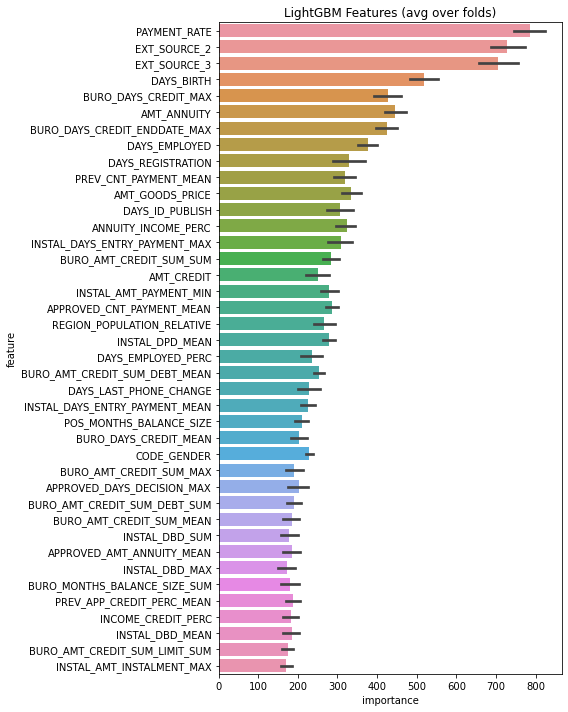

In [62]:
display_importances(feature_importance_df)

In [63]:
feature_importance_df

,feature,importance,fold
0,CODE_GENDER,218,1
1,FLAG_OWN_CAR,153,1
2,FLAG_OWN_REALTY,31,1
3,CNT_CHILDREN,10,1
4,AMT_INCOME_TOTAL,140,1
...,...,...,...
501,INSTAL_AMT_PAYMENT_SUM,168,10
502,INSTAL_DAYS_ENTRY_PAYMENT_MAX,237,10
503,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,181,10
504,INSTAL_DAYS_ENTRY_PAYMENT_SUM,129,10


In [65]:
cols = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40].index
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
best_features

,feature,importance,fold
0,CODE_GENDER,218,1
5,AMT_CREDIT,277,1
6,AMT_ANNUITY,508,1
7,AMT_GOODS_PRICE,369,1
8,REGION_POPULATION_RELATIVE,313,1
...,...,...,...
486,INSTAL_DBD_SUM,144,10
495,INSTAL_AMT_INSTALMENT_MAX,186,10
498,INSTAL_AMT_PAYMENT_MIN,223,10
502,INSTAL_DAYS_ENTRY_PAYMENT_MAX,237,10


In [66]:
best_features.sort_values(by="importance", ascending=False)

,feature,importance,fold
199,PAYMENT_RATE,873,9
199,PAYMENT_RATE,845,2
29,EXT_SOURCE_2,843,6
199,PAYMENT_RATE,840,6
199,PAYMENT_RATE,830,4
...,...,...,...
196,INCOME_CREDIT_PERC,123,8
458,APPROVED_DAYS_DECISION_MAX,121,8
485,INSTAL_DBD_MEAN,114,8
484,INSTAL_DBD_MAX,111,8


In [67]:
best_feat = feature_importance_df[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)[:40]
best_feat

,importance
feature,
PAYMENT_RATE,785.8
EXT_SOURCE_2,729.1
EXT_SOURCE_3,704.5
DAYS_BIRTH,517.7
AMT_ANNUITY,446.4
BURO_DAYS_CREDIT_MAX,426.6
BURO_DAYS_CREDIT_ENDDATE_MAX,424.0
DAYS_EMPLOYED,376.5
AMT_GOODS_PRICE,333.6


In [74]:
feats20= cols[0:20]
feats20

Index(['PAYMENT_RATE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'AMT_ANNUITY', 'BURO_DAYS_CREDIT_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MAX',
       'DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'DAYS_REGISTRATION',
       'ANNUITY_INCOME_PERC', 'PREV_CNT_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'DAYS_ID_PUBLISH',
       'APPROVED_CNT_PAYMENT_MEAN', 'BURO_AMT_CREDIT_SUM_SUM',
       'INSTAL_DPD_MEAN', 'INSTAL_AMT_PAYMENT_MIN',
       'REGION_POPULATION_RELATIVE', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN'],
      dtype='object', name='feature')

In [75]:
#Refaire tourner le modèle avec les 20 features les plus importantes

Train shape: (172764, 509), test shape: (28861, 507)
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.780066	training's binary_logloss: 0.244532	valid_1's auc: 0.760308	valid_1's binary_logloss: 0.250747
[400]	training's auc: 0.799999	training's binary_logloss: 0.23704	valid_1's auc: 0.765265	valid_1's binary_logloss: 0.248589
[600]	training's auc: 0.814234	training's binary_logloss: 0.23189	valid_1's auc: 0.766328	valid_1's binary_logloss: 0.248103
[800]	training's auc: 0.826345	training's binary_logloss: 0.227487	valid_1's auc: 0.767053	valid_1's binary_logloss: 0.247872
[1000]	training's auc: 0.837141	training's binary_logloss: 0.223505	valid_1's auc: 0.767284	valid_1's binary_logloss: 0.247794
[1200]	training's auc: 0.846935	training's binary_logloss: 0.219695	valid_1's auc: 0.767262	valid_1's binary_logloss: 0.24781
Fold  1 AUC : 0.767705
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.780793	training's binary_logloss: 0.24435	valid_1's auc: 0.756391	valid_1's binary_logloss: 0.251137
[400]	training's auc: 0.800718	training's binary_logloss: 0.236852	valid_1's auc: 0.762316	valid_1's binary_logloss: 0.248875
[600]	training's auc: 0.814819	training's binary_logloss: 0.231719	valid_1's auc: 0.76391	valid_1's binary_logloss: 0.248307
[800]	training's auc: 0.826612	training's binary_logloss: 0.227481	valid_1's auc: 0.763978	valid_1's binary_logloss: 0.248316
Fold  2 AUC : 0.764044
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.781107	training's binary_logloss: 0.244237	valid_1's auc: 0.753999	valid_1's binary_logloss: 0.252383
[400]	training's auc: 0.800891	training's binary_logloss: 0.236705	valid_1's auc: 0.760542	valid_1's binary_logloss: 0.250197
[600]	training's auc: 0.814892	training's binary_logloss: 0.231618	valid_1's auc: 0.76195	valid_1's binary_logloss: 0.249819
[800]	training's auc: 0.827038	training's binary_logloss: 0.227156	valid_1's auc: 0.762576	valid_1's binary_logloss: 0.249794
Fold  3 AUC : 0.762724
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.78188	training's binary_logloss: 0.243986	valid_1's auc: 0.742636	valid_1's binary_logloss: 0.255097
[400]	training's auc: 0.80207	training's binary_logloss: 0.23633	valid_1's auc: 0.74923	valid_1's binary_logloss: 0.253252
[600]	training's auc: 0.81691	training's binary_logloss: 0.230932	valid_1's auc: 0.751321	valid_1's binary_logloss: 0.252842
[800]	training's auc: 0.828842	training's binary_logloss: 0.226495	valid_1's auc: 0.751615	valid_1's binary_logloss: 0.252848
Fold  4 AUC : 0.751898
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.781183	training's binary_logloss: 0.244322	valid_1's auc: 0.753944	valid_1's binary_logloss: 0.252238
[400]	training's auc: 0.801772	training's binary_logloss: 0.236606	valid_1's auc: 0.759135	valid_1's binary_logloss: 0.250548
[600]	training's auc: 0.815736	training's binary_logloss: 0.231518	valid_1's auc: 0.759588	valid_1's binary_logloss: 0.25048
Fold  5 AUC : 0.759613
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.780603	training's binary_logloss: 0.244492	valid_1's auc: 0.757296	valid_1's binary_logloss: 0.250981
[400]	training's auc: 0.800828	training's binary_logloss: 0.236861	valid_1's auc: 0.765575	valid_1's binary_logloss: 0.248279
[600]	training's auc: 0.814953	training's binary_logloss: 0.231691	valid_1's auc: 0.766827	valid_1's binary_logloss: 0.247703
[800]	training's auc: 0.827099	training's binary_logloss: 0.227222	valid_1's auc: 0.767156	valid_1's binary_logloss: 0.247541
Fold  6 AUC : 0.767211
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.780079	training's binary_logloss: 0.244697	valid_1's auc: 0.760147	valid_1's binary_logloss: 0.249912
[400]	training's auc: 0.800934	training's binary_logloss: 0.237017	valid_1's auc: 0.766057	valid_1's binary_logloss: 0.247221
[600]	training's auc: 0.814784	training's binary_logloss: 0.23197	valid_1's auc: 0.767665	valid_1's binary_logloss: 0.246506
[800]	training's auc: 0.826652	training's binary_logloss: 0.227597	valid_1's auc: 0.768033	valid_1's binary_logloss: 0.246428
Fold  7 AUC : 0.768175
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.780451	training's binary_logloss: 0.24461	valid_1's auc: 0.758638	valid_1's binary_logloss: 0.250299
[400]	training's auc: 0.8015	training's binary_logloss: 0.236746	valid_1's auc: 0.762758	valid_1's binary_logloss: 0.248444
Fold  8 AUC : 0.762988
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.781444	training's binary_logloss: 0.244175	valid_1's auc: 0.752176	valid_1's binary_logloss: 0.252879
[400]	training's auc: 0.801614	training's binary_logloss: 0.236619	valid_1's auc: 0.758886	valid_1's binary_logloss: 0.250794
[600]	training's auc: 0.815591	training's binary_logloss: 0.231516	valid_1's auc: 0.759474	valid_1's binary_logloss: 0.250597
Fold  9 AUC : 0.759651
[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a f

[200]	training's auc: 0.781074	training's binary_logloss: 0.244255	valid_1's auc: 0.753834	valid_1's binary_logloss: 0.252586
[400]	training's auc: 0.801368	training's binary_logloss: 0.236738	valid_1's auc: 0.760097	valid_1's binary_logloss: 0.250205
[600]	training's auc: 0.81523	training's binary_logloss: 0.231709	valid_1's auc: 0.761915	valid_1's binary_logloss: 0.249615
[800]	training's auc: 0.826879	training's binary_logloss: 0.227431	valid_1's auc: 0.761897	valid_1's binary_logloss: 0.249619
Fold 10 AUC : 0.762115
Full AUC score 0.762569


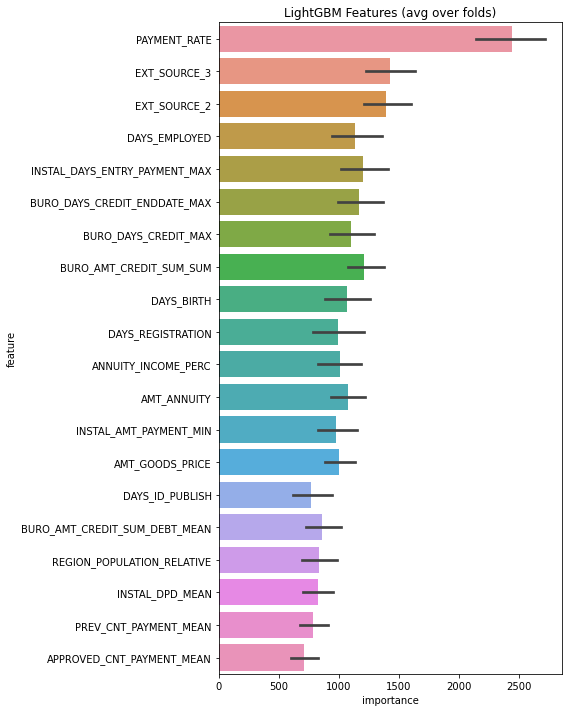

In [83]:
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve


# LightGBM  with Stratified KFold
# Parameters from Tilii kernel: https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code



import re
# Divide in training/validation and test data 
train_df_lgbmcNaN = train_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df_lgbmcNaN = test_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
print("Train shape: {}, test shape: {}".format(train_df_lgbmcNaN.shape, test_df_lgbmcNaN.shape))


# Cross validation model

folds = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

# Create arrays and dataframes to store results
oof_preds = np.zeros(train_df_lgbmcNaN.shape[0])
sub_preds = np.zeros(test_df_lgbmcNaN.shape[0])
feature20_importance_df = pd.DataFrame()

    
for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df_lgbmcNaN[feats20], train_df_lgbmcNaN['TARGET'])):
    train_x, train_y = train_df_lgbmcNaN[feats20].iloc[train_idx], train_df_lgbmcNaN['TARGET'].iloc[train_idx]
    valid_x, valid_y = train_df_lgbmcNaN[feats20].iloc[valid_idx], train_df_lgbmcNaN['TARGET'].iloc[valid_idx]

    # LightGBM parameters found by Bayesian optimization
    clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )

    clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], 
            eval_metric= 'auc', verbose= 200, early_stopping_rounds= 200)

    oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
    sub_preds += clf.predict_proba(test_df_lgbmcNaN[feats20], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = feats20
    fold_importance_df["importance"] = clf.feature_importances_
    fold_importance_df["fold"] = n_fold + 1
    feature20_importance_df = pd.concat([feature20_importance_df, fold_importance_df], axis=0)
    print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))


print('Full AUC score %.6f' % roc_auc_score(train_df_lgbmcNaN['TARGET'], oof_preds))

# Write submission file and plot feature importance
test_df_lgbmcNaN['TARGET'] = sub_preds
test_df_lgbmcNaN[['SK_ID_CURR', 'TARGET']].to_csv('test_df_lgbmcNaN_pred.csv', index= False)
display_importances(feature20_importance_df)



In [84]:
import re


categorical_feature_mask20lgbmc = train_df_lgbmcNaN .dtypes=='uint8'
categorical_features20lgbmc = train_df_lgbmcNaN .columns[categorical_feature_mask20lgbmc].tolist()
categorical_features20lgbmc = categorical_features20lgbmc + ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']

float_feature_mask20lgbmc = train_df_lgbmcNaN .dtypes=='float64'
float_features20lgbmc = train_df_lgbmcNaN .columns[float_feature_mask20lgbmc].tolist()
del float_features20lgbmc[0]

integer_feature_mask20lgbmc = train_df_lgbmcNaN .dtypes=='int64'
integer_features20lgbmc = train_df_lgbmcNaN .columns[integer_feature_mask20lgbmc].tolist()
del integer_features20lgbmc[0:5]

In [85]:
#preprocessor_lgbmc20r = ColumnTransformer(
#    transformers=[('scaler', StandardScaler(), float_features20lgbmc)],
#    remainder='passthrough')

In [86]:

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve
from lightgbm import LGBMClassifier

import re
# Divide in training/validation and test data 
train_df_lgbmcNaN = train_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
test_df_lgbmcNaN = test_df20r.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# LightGBM parameters found by Bayesian optimization
clf = LGBMClassifier(
            nthread=4,
            n_estimators=10000,
            learning_rate=0.02,
            num_leaves=34,
            colsample_bytree=0.9497036,
            subsample=0.8715623,
            max_depth=8,
            reg_alpha=0.041545473,
            reg_lambda=0.0735294,
            min_split_gain=0.0222415,
            min_child_weight=39.3259775,
            silent=-1,
            verbose=-1, )


cv = StratifiedKFold(n_splits= 10, shuffle=True, random_state=1001)

X = train_df_lgbmcNaN [feats20]
y = train_df_lgbmcNaN ['TARGET']




model_pipeline = make_pipeline(clf)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,
                                                    random_state=0)
model_pipeline.fit(X_train, y_train)
model_pipeline.score(X_test, y_test)

C:\Users\chiqu\anaconda3\lib\site-packages\lightgbm\sklearn.py:598: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via keyword arguments instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=4 will be ignored. Current value: num_threads=-1


0.9142967393401505

In [93]:
feats20

Index(['PAYMENT_RATE', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'AMT_ANNUITY', 'BURO_DAYS_CREDIT_MAX', 'BURO_DAYS_CREDIT_ENDDATE_MAX',
       'DAYS_EMPLOYED', 'AMT_GOODS_PRICE', 'DAYS_REGISTRATION',
       'ANNUITY_INCOME_PERC', 'PREV_CNT_PAYMENT_MEAN',
       'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'DAYS_ID_PUBLISH',
       'APPROVED_CNT_PAYMENT_MEAN', 'BURO_AMT_CREDIT_SUM_SUM',
       'INSTAL_DPD_MEAN', 'INSTAL_AMT_PAYMENT_MIN',
       'REGION_POPULATION_RELATIVE', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN'],
      dtype='object', name='feature')

In [100]:
col_test_df_lgbmcNaN= feats20.to_list()
col_test_df_lgbmcNaN

['PAYMENT_RATE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'AMT_ANNUITY',
 'BURO_DAYS_CREDIT_MAX',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'DAYS_EMPLOYED',
 'AMT_GOODS_PRICE',
 'DAYS_REGISTRATION',
 'ANNUITY_INCOME_PERC',
 'PREV_CNT_PAYMENT_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'DAYS_ID_PUBLISH',
 'APPROVED_CNT_PAYMENT_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'INSTAL_DPD_MEAN',
 'INSTAL_AMT_PAYMENT_MIN',
 'REGION_POPULATION_RELATIVE',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN']

In [101]:
col_test_df_lgbmcNaN.append('SK_ID_CURR')
col_test_df_lgbmcNaN

['PAYMENT_RATE',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'DAYS_BIRTH',
 'AMT_ANNUITY',
 'BURO_DAYS_CREDIT_MAX',
 'BURO_DAYS_CREDIT_ENDDATE_MAX',
 'DAYS_EMPLOYED',
 'AMT_GOODS_PRICE',
 'DAYS_REGISTRATION',
 'ANNUITY_INCOME_PERC',
 'PREV_CNT_PAYMENT_MEAN',
 'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
 'DAYS_ID_PUBLISH',
 'APPROVED_CNT_PAYMENT_MEAN',
 'BURO_AMT_CREDIT_SUM_SUM',
 'INSTAL_DPD_MEAN',
 'INSTAL_AMT_PAYMENT_MIN',
 'REGION_POPULATION_RELATIVE',
 'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
 'SK_ID_CURR']

In [128]:
test_df_lgbmcNaN.shape

(28861, 507)

In [102]:
test_df_lgbmcNaN[col_test_df_lgbmcNaN].shape

(28861, 21)

In [103]:
test20_df_lgbmcNaN = test_df_lgbmcNaN[col_test_df_lgbmcNaN]

In [104]:
print(train_df_lgbmcNaN[feats20].shape)
print(test20_df_lgbmcNaN .shape)

(172764, 20)
(28861, 21)


In [105]:
test20_df_lgbmcNaN.to_csv('test20_df_lgbmcNaN.csv')

In [130]:
test_df_lgbmcNaN.to_csv('test_df_lgbmcNaN.csv')

In [106]:
test_df_lgbmcNaN ['SK_ID_CURR'].describe()

count     28861.000000
mean     277278.248952
std      103242.633443
min      100001.000000
25%      187259.000000
50%      276906.000000
75%      367481.000000
max      456250.000000
Name: SK_ID_CURR, dtype: float64

In [107]:
train_df_lgbmcNaN ['SK_ID_CURR'].describe()

count    172764.000000
mean     278140.926015
std      102973.451967
min      100002.000000
25%      188793.750000
50%      278089.500000
75%      367458.250000
max      456255.000000
Name: SK_ID_CURR, dtype: float64

In [108]:
model_pipeline

Pipeline(steps=[('lgbmclassifier',
                 LGBMClassifier(colsample_bytree=0.9497036, learning_rate=0.02,
                                max_depth=8, min_child_weight=39.3259775,
                                min_split_gain=0.0222415, n_estimators=10000,
                                nthread=4, num_leaves=34, reg_alpha=0.041545473,
                                reg_lambda=0.0735294, silent=-1,
                                subsample=0.8715623, verbose=-1))])

In [109]:
import joblib
joblib.dump(model_pipeline, 'pipeline_bank_lgbm.joblib')

['pipeline_bank_lgbm.joblib']

In [110]:
from mlflow.models.signature import infer_signature
signature = infer_signature(X_train, y_train)

C:\Users\chiqu\anaconda3\lib\site-packages\mlflow\models\signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  inputs = _infer_schema(model_input)


In [112]:
import mlflow.sklearn
mlflow.sklearn.save_model(model_pipeline, 'mlflow_model_bank_lgbm', signature=signature)

In [39]:
!pip install lime

  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=e32876daa7af08940f1aee5722f73ae8ff5a055fe6e15700dd15427e0c83c806
  Stored in directory: c:\users\chiqu\appdata\local\pip\cache\wheels\ed\d7\c9\5a0130d06d6310bc6cbe55220e6e72dcb8c4eff9a478717066
Successfully built lime


In [113]:
features = X_train.columns.tolist()

In [114]:
len(features)

20

In [115]:
from lime import lime_tabular


explainer = lime_tabular.LimeTabularExplainer(X_train.values, mode="classification", feature_names= features)
explainer

In [117]:
feat_client = test20_df_lgbmcNaN.loc[test20_df_lgbmcNaN['SK_ID_CURR'] == 100001,:]
feat_client

,PAYMENT_RATE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_ANNUITY,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_ENDDATE_MAX,DAYS_EMPLOYED,AMT_GOODS_PRICE,DAYS_REGISTRATION,...,PREV_CNT_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,DAYS_ID_PUBLISH,APPROVED_CNT_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_SUM,INSTAL_DPD_MEAN,INSTAL_AMT_PAYMENT_MIN,REGION_POPULATION_RELATIVE,BURO_AMT_CREDIT_SUM_DEBT_MEAN,SK_ID_CURR
307511,0.036147,0.789654,0.15952,-19241,20560.5,-49.0,1778.0,-2329.0,450000.0,-5170.0,...,8.0,-1628.0,-812,8.0,1453365.0,1.571429,3951.0,0.01885,85240.928571,100001


In [118]:
feat_client.shape

(1, 21)

In [119]:
features_client = feat_client.drop('SK_ID_CURR',axis=1)
features_client

,PAYMENT_RATE,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH,AMT_ANNUITY,BURO_DAYS_CREDIT_MAX,BURO_DAYS_CREDIT_ENDDATE_MAX,DAYS_EMPLOYED,AMT_GOODS_PRICE,DAYS_REGISTRATION,ANNUITY_INCOME_PERC,PREV_CNT_PAYMENT_MEAN,INSTAL_DAYS_ENTRY_PAYMENT_MAX,DAYS_ID_PUBLISH,APPROVED_CNT_PAYMENT_MEAN,BURO_AMT_CREDIT_SUM_SUM,INSTAL_DPD_MEAN,INSTAL_AMT_PAYMENT_MIN,REGION_POPULATION_RELATIVE,BURO_AMT_CREDIT_SUM_DEBT_MEAN
307511,0.036147,0.789654,0.15952,-19241,20560.5,-49.0,1778.0,-2329.0,450000.0,-5170.0,0.1523,8.0,-1628.0,-812,8.0,1453365.0,1.571429,3951.0,0.01885,85240.928571


In [121]:
features_client.shape

(1, 20)

In [122]:
p = model_pipeline.predict_proba(features_client)[0]
p

array([0.96760306, 0.03239694])

In [124]:
import random
idx = random.randint(1, 100)
#X_test.values[idx]
model_pipeline.predict_proba([X_test.values[3]])

print("Prediction : ", model_pipeline.predict_proba([X_test.values[idx]]).reshape(1,-1)[0,1])
#print("Prediction : ", test_df_lgbmc_pred.iloc[idx,1])
print("Actual :     ", y_test.values[idx])



Prediction :  0.15305304855306148
Actual :      0.0


In [125]:
explanation = explainer.explain_instance(X_test.values[idx], model_pipeline.predict_proba, num_features=len(features))
#explanation

In [126]:
explanation.show_in_notebook()

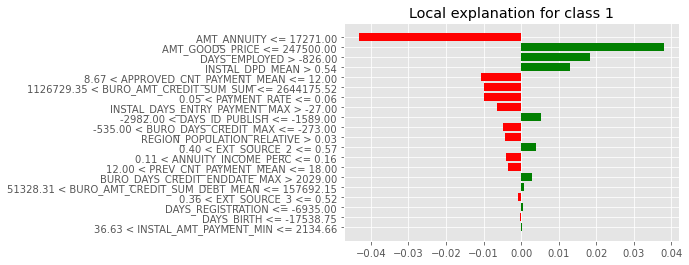

In [127]:
with plt.style.context("ggplot"):
    explanation.as_pyplot_figure()